# Μέρος Δ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SVM

Θα χρησιμοποιήσουμε Bayesian Optimization μέσω του framework Optuna για να κάνουμε hyperparameter tuning. Με αυτόν τον τρόπο θα μειωθεί ο αριθμός των ελέγχων που πρέπει να κάνουμε, μειώνοντας έτσι το υπολογιστικό κόστος και αυξάνοντας την ταχύτητα. Δε θα χρειάζεται να ελέγχουμε όλους τους συνδυασμούς των υπερπαραμέτρων (όπως με GridSearch), αλλά θα ελέγχονται μόνο οι συνδυασμοί που πιθανώς θα είναι πιο αποδοτικοί με βάση τα αποτελέσματα των προηγούμενων δοκιμών (trials) και οι συνδυασμοί που δεν αποδίδουν καλά, θα αφαιρούνται πριν ολοκληρωθούν (pruning). Θα μελετηθούν συνδυασμοί 2 υπερπαραμέτρων: του C (regularization parameter) και του gamma (το kernel έχει επιλεγεί εξαρχής να είναι το rbf, γιατί αποδίδει καλά σε υψηλές διαστάσεις και επίσης σε δοκιμές με άλλα kernels -polynomial, linear- η απόδοση του μοντέλου δεν ήταν το ίδιο καλή).

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


### PCA + RFE + Variance Threshold

Θα χρησιμοποιήσουμε PCA για dimensionality reduction (κρατώντας 95% του variance), βάζοντας ένα variance threshold (0.01) για να αφαιρέσουμε features με χαμηλό variance (δηλαδή όχι χρήσιμα) και κάνοντας RFE για να κρατήσουμε το top 75% των features.

#### Initial set of hyperparameters
{'C': 2.8476195313586885, 'gamma': 'scale'}

In [ ]:
# mean cv 86.43% , test 87.25%
#PCA + VARIANCE THRESHOLD + RFE
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA #dimensionality reduction
from sklearn.preprocessing import StandardScaler #scaling
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.pipeline import Pipeline

#load dataset
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)

#separate features & labels
X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels

#split dataset into training 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize the features (-mean & unit variance) before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#PCA for dimensionality reduction (95% variance explained)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#variance threshold to remove low-variance features
variance_threshold = VarianceThreshold(threshold=0.01)  #remove features with low variance (<0.01)
X_train_pca = variance_threshold.fit_transform(X_train_pca)
X_test_pca = variance_threshold.transform(X_test_pca)

#Recursive Feature Elimination (RFE) for feature selection
#use LinearSVC for feature selection, because it supports 'coef_' attribute
linear_svc = LinearSVC(C=1.0, max_iter=10000, random_state=42)
selector = RFE(estimator=linear_svc, n_features_to_select=0.75, step=1)  #select top 75% features
X_train_selected = selector.fit_transform(X_train_pca, y_train)
X_test_selected = selector.transform(X_test_pca)

#Stratified K-Fold cross-validation (same distribution of data in folds)
stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#objective function for optuna
def objective(trial):
    #hyperparameters for tuning
    C = trial.suggest_loguniform('C', 1e-2, 1e2)  #regularization parameter C
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  #gamma for RBF kernel

    #SVM model with class_weight='balanced'
    svm_rbf = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced', random_state=42)

    #cross-validation with Stratified K-Fold
    scores = cross_val_score(svm_rbf, X_train_selected, y_train, cv=stratified_kf, scoring='accuracy')

    #return mean of cross-validation scores
    return np.mean(scores)

#create Optuna study for optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  #perform 50 trials

#get the best hyperparameters from optuna trials
best_params = study.best_params
print(f"Best hyperparameters from Optuna: {best_params}")

#train svm with the best hyperparameters
best_svm_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf', class_weight='balanced', random_state=42)
best_svm_model.fit(X_train_selected, y_train)

#evaluate model on test set
y_pred = best_svm_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of SVM with PCA and RBF kernel (class_weight='balanced') on test set: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#cv accuracy with Stratified K-Fold on training data
cv_scores = cross_val_score(best_svm_model, X_train_selected, y_train, cv=stratified_kf, scoring='accuracy')
print("\nStratified K-Fold Cross-validation accuracy scores (10-fold):", cv_scores)
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")


[I 2025-01-04 20:00:09,661] A new study created in memory with name: no-name-031e300c-6db4-424a-83c9-0d7a336f3a7f
<ipython-input-6-a06fba1bd1db>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  #regularization parameter C
[I 2025-01-04 20:01:06,118] Trial 0 finished with value: 0.8638798283261803 and parameters: {'C': 2.832737675383588, 'gamma': 'scale'}. Best is trial 0 with value: 0.8638798283261803.
<ipython-input-6-a06fba1bd1db>:53: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  #regularization parameter C
[I 2025-01-04 20:02:37,964] Trial 1 finished with value: 0.75636685060

Best hyperparameters from Optuna: {'C': 2.8476195313586885, 'gamma': 'scale'}
Accuracy of SVM with PCA and RBF kernel (class_weight='balanced') on test set: 0.8725

Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.97      0.96       377
           2       0.75      0.74      0.75       332
           3       0.93      0.94      0.93       349
           4       0.93      0.91      0.92       325
           5       0.79      0.78      0.79       366

    accuracy                           0.87      1749
   macro avg       0.87      0.87      0.87      1749
weighted avg       0.87      0.87      0.87      1749


Confusion Matrix:
[[367   4   5   1   0]
 [  3 247   7   8  67]
 [  9   5 328   7   0]
 [  0  10  10 297   8]
 [  5  65   3   6 287]]

Stratified K-Fold Cross-validation accuracy scores (10-fold): [0.86571429 0.86428571 0.86428571 0.88571429 0.86409156 0.85550787
 0.85550787 0.87410587 0.85550787 0.8583691 ]
Mean cross-v

Από το hyperparameter tuning προκύπτουν:

Best hyperparameters from Optuna: {'C': 2.8476195313586885, 'gamma': 'scale'}

Αυτά προέκυψαν από split του dataset σε 80% training και 20% test sets και η τιμή του C είναι λίγο μεγάλη. Τώρα θα δοκιμάσουμε μια πιο ενδελεχή και ακριβή σε πόρους διαδικασία με nested CV: ένα outer 5-fold και ένα inner 5-fold, όπου στο inner κάνουμε hyperparameter tuning και στο outer ελέγχουμε την απόδοση των hyperparameters που βρήκαμε.

Πιο αναλυτικά στο inner CV, δοκιμάζονται διάφορες τιμές υπερπαραμέτρων, με τη χρήση της Optuna για αναζήτηση του καλύτερου συνδυασμού υπερπαραμέτρων. Οι υπερπαράμετροι που βρίσκονται από το inner CV εφαρμόζονται στη συνέχεια στο μοντέλο που εκπαιδεύεται στο αντίστοιχο fold του outer CV. Στο outer CV, ελέγχεται η γενική απόδοση του μοντέλου, χρησιμοποιώντας δεδομένα που δεν έχουν χρησιμοποιηθεί ούτε για εκπαίδευση ούτε για tuning. Η απόδοση υπολογίζεται ξεχωριστά σε κάθε outer fold και τελικά υπολογίζεται ο μέσος όρος για να εκτιμηθεί η συνολική ικανότητα γενίκευσης του μοντέλου.

Έτσι μειώνεται η πιθανότητα το μοντέλο να έχει optimistic bias (συμβαίνει όταν χρησιμοποιείται το ίδιο dataset και για tuning και για εξέταση της απόδοσης του μοντέλου στο CV) και να κάνει overfit, αυξάνοντας έτσι την ικανότητα γενίκευσης. Σε αυτή τη διαδικασία το μοντέλο εκπαιδεύεται και τεστάρεται ξεχωριστά σε καθένα από τα 5 outer folds.

#### 1st set of hyperparameters
'C': 2.1946408926552823, 'gamma': 'auto'

In [ ]:
# mean cv nested 86.84%, test 88.16% => 'C': 2.1946408926552823, 'gamma': 'auto'
import numpy as np
import pandas as pd
import optuna
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.pipeline import Pipeline

#load dataset
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)

#separate features & labels
X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels -> last column

#standardize features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA for dimensionality reduction (95% variance explained)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

#variance thresholding -> remove low-variance features
variance_threshold = VarianceThreshold(threshold=0.01)
X_pca = variance_threshold.fit_transform(X_pca)

#RFE for feature selection
linear_svc = LinearSVC(C=1.0, max_iter=10000, random_state=42)  #linear SVM for feature selection
selector = RFE(estimator=linear_svc, n_features_to_select=0.75, step=1)  #select top 75% features
X_selected = selector.fit_transform(X_pca, y)

#objective function for Optuna (inner CV)
def objective(trial, X_selected, y):
    #hyperparameters for tuning
    C = trial.suggest_loguniform('C', 1e-2, 1e2)  #regularization parameter C
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  #gamma for RBF kernel

    #class_weight='balanced'
    svm_rbf = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced', random_state=42)

    #CV using Stratified K-Fold (inner loop)
    stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(svm_rbf, X_selected, y, cv=stratified_kf, scoring='accuracy')

    #print each trial's hyperparameters and accuracy
    print(f"Trial {trial.number}: C={C}, gamma={gamma}, accuracy={np.mean(scores):.4f}")

    #return mean of cv scores
    return np.mean(scores)

#outer StratifiedKFold (5-fold cross-validation)
outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

outer_accuracies = []
outer_class_reports = []
outer_conf_matrices = []

#outer loop for nested cv
for outer_fold, (train_idx, test_idx) in enumerate(outer_kf.split(X_selected, y), 1):
    #split data into training and testing for this outer fold
    X_train_fold, X_test_fold = X_selected[train_idx], X_selected[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    print(f"\nOuter Fold {outer_fold}: Optimizing hyperparameters...")

    #create study for hyperparameter tuning (inner loop)
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train_fold, y_train_fold), n_trials=50)  #50 trials

    #get the best hyperparameters from optuna
    best_params = study.best_params
    print(f"Best hyperparameters from Optuna for Outer Fold {outer_fold}: {best_params}")

    # train model with the best hyperparameters
    best_svm_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf', class_weight='balanced', random_state=42)
    best_svm_model.fit(X_train_fold, y_train_fold)

    #evaluate model on the outer test set
    y_pred = best_svm_model.predict(X_test_fold)
    accuracy = accuracy_score(y_test_fold, y_pred)
    outer_accuracies.append(accuracy)

    #get classification report and confusion matrix for this fold
    outer_class_reports.append(classification_report(y_test_fold, y_pred))
    outer_conf_matrices.append(confusion_matrix(y_test_fold, y_pred))

    print(f"\nAccuracy for Outer Fold {outer_fold}: {accuracy:.4f}")
    print(f"Classification Report for Outer Fold {outer_fold}:\n{classification_report(y_test_fold, y_pred)}")
    print(f"Confusion Matrix for Outer Fold {outer_fold}:\n{confusion_matrix(y_test_fold, y_pred)}")

#print average accuracy and overall results
mean_accuracy = np.mean(outer_accuracies)
print(f"\nMean accuracy across all outer folds: {mean_accuracy:.4f}")
print(f"\nOverall Classification Report across all outer folds:\n{np.mean(outer_class_reports, axis=0)}")
print(f"\nOverall Confusion Matrix across all outer folds:\n{np.mean(outer_conf_matrices, axis=0)}")


[I 2024-12-25 13:24:20,502] A new study created in memory with name: no-name-b9a557bb-0d44-4231-b8a6-6986393c1723



Outer Fold 1: Optimizing hyperparameters...


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:24:43,218] Trial 0 finished with value: 0.8644576495984767 and parameters: {'C': 48.48052828044615, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 0: C=48.48052828044615, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:25:07,787] Trial 1 finished with value: 0.8101253603381119 and parameters: {'C': 0.13897775026771345, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 1: C=0.13897775026771345, gamma=auto, accuracy=0.8101


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:25:30,107] Trial 2 finished with value: 0.8268542521175455 and parameters: {'C': 0.23598868855691088, 'gamma': 'scale'}. Best is trial 0 with value: 0.8644576495984767.


Trial 2: C=0.23598868855691088, gamma=scale, accuracy=0.8269


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:25:48,462] Trial 3 finished with value: 0.8415801804068102 and parameters: {'C': 0.45654263100871817, 'gamma': 'scale'}. Best is trial 0 with value: 0.8644576495984767.


Trial 3: C=0.45654263100871817, gamma=scale, accuracy=0.8416


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:26:08,032] Trial 4 finished with value: 0.8451541618221068 and parameters: {'C': 0.473839617534935, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 4: C=0.473839617534935, gamma=auto, accuracy=0.8452


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:26:39,821] Trial 5 finished with value: 0.7650867521354411 and parameters: {'C': 0.042307419442056855, 'gamma': 'scale'}. Best is trial 0 with value: 0.8644576495984767.


Trial 5: C=0.042307419442056855, gamma=scale, accuracy=0.7651


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:26:59,089] Trial 6 finished with value: 0.8603112175976915 and parameters: {'C': 1.7243210283173247, 'gamma': 'scale'}. Best is trial 0 with value: 0.8644576495984767.


Trial 6: C=1.7243210283173247, gamma=scale, accuracy=0.8603


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:27:18,891] Trial 7 finished with value: 0.8621696879336456 and parameters: {'C': 1.7146334973158301, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 7: C=1.7146334973158301, gamma=auto, accuracy=0.8622


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:27:46,359] Trial 8 finished with value: 0.7928239157133493 and parameters: {'C': 0.09094537791597816, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 8: C=0.09094537791597816, gamma=auto, accuracy=0.7928


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:28:29,406] Trial 9 finished with value: 0.6468428808233144 and parameters: {'C': 0.011519660237828053, 'gamma': 'scale'}. Best is trial 0 with value: 0.8644576495984767.


Trial 9: C=0.011519660237828053, gamma=scale, accuracy=0.6468


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:28:49,391] Trial 10 finished with value: 0.8644576495984767 and parameters: {'C': 79.11748653737945, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 10: C=79.11748653737945, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:29:10,302] Trial 11 finished with value: 0.8644576495984767 and parameters: {'C': 82.76626090035654, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 11: C=82.76626090035654, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:29:31,964] Trial 12 finished with value: 0.8644576495984767 and parameters: {'C': 81.2429627874338, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 12: C=81.2429627874338, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:29:52,201] Trial 13 finished with value: 0.8644576495984767 and parameters: {'C': 12.468724775055, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 13: C=12.468724775055, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:30:14,855] Trial 14 finished with value: 0.8644576495984767 and parameters: {'C': 11.514325635540162, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 14: C=11.514325635540162, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:30:35,870] Trial 15 finished with value: 0.8644576495984767 and parameters: {'C': 17.532688897395197, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 15: C=17.532688897395197, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:30:57,483] Trial 16 finished with value: 0.8644576495984767 and parameters: {'C': 26.508992629832807, 'gamma': 'auto'}. Best is trial 0 with value: 0.8644576495984767.


Trial 16: C=26.508992629832807, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:31:18,551] Trial 17 finished with value: 0.865601528171052 and parameters: {'C': 2.5479043660425194, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 17: C=2.5479043660425194, gamma=auto, accuracy=0.8656


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:31:39,094] Trial 18 finished with value: 0.8643146903418648 and parameters: {'C': 5.09960449335847, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 18: C=5.09960449335847, gamma=auto, accuracy=0.8643


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:32:01,436] Trial 19 finished with value: 0.8647436703715407 and parameters: {'C': 4.46322729989657, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 19: C=4.46322729989657, gamma=auto, accuracy=0.8647


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:32:21,961] Trial 20 finished with value: 0.8653157119176687 and parameters: {'C': 3.3603057031550585, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 20: C=3.3603057031550585, gamma=auto, accuracy=0.8653


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:32:44,628] Trial 21 finished with value: 0.8648865273683123 and parameters: {'C': 4.0455805589020155, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 21: C=4.0455805589020155, gamma=auto, accuracy=0.8649


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:33:05,209] Trial 22 finished with value: 0.8651725481413763 and parameters: {'C': 3.980082122869069, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 22: C=3.980082122869069, gamma=auto, accuracy=0.8652


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:33:24,171] Trial 23 finished with value: 0.8597384602326821 and parameters: {'C': 1.1370505943488183, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 23: C=1.1370505943488183, gamma=auto, accuracy=0.8597


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:33:46,157] Trial 24 finished with value: 0.8651727526610568 and parameters: {'C': 3.1584409955965107, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 24: C=3.1584409955965107, gamma=auto, accuracy=0.8652


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:34:04,799] Trial 25 finished with value: 0.8531613118301342 and parameters: {'C': 0.6888421566289996, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 25: C=0.6888421566289996, gamma=auto, accuracy=0.8532


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:34:23,074] Trial 26 finished with value: 0.8630275457331569 and parameters: {'C': 2.1799651690062785, 'gamma': 'scale'}. Best is trial 17 with value: 0.865601528171052.


Trial 26: C=2.1799651690062785, gamma=scale, accuracy=0.8630


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:34:45,318] Trial 27 finished with value: 0.8644576495984767 and parameters: {'C': 7.931161178814476, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 27: C=7.931161178814476, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:35:04,404] Trial 28 finished with value: 0.8585946839199469 and parameters: {'C': 1.0397771357175924, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 28: C=1.0397771357175924, gamma=auto, accuracy=0.8586


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:35:25,114] Trial 29 finished with value: 0.8644576495984767 and parameters: {'C': 25.371885660773355, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 29: C=25.371885660773355, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:35:47,135] Trial 30 finished with value: 0.8653155073979881 and parameters: {'C': 2.665491912469184, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 30: C=2.665491912469184, gamma=auto, accuracy=0.8653


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:36:07,457] Trial 31 finished with value: 0.8648867318879928 and parameters: {'C': 3.0927063802775594, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 31: C=3.0927063802775594, gamma=auto, accuracy=0.8649


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:36:29,161] Trial 32 finished with value: 0.8644576495984767 and parameters: {'C': 7.474354569064147, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 32: C=7.474354569064147, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:36:50,322] Trial 33 finished with value: 0.8653156096578283 and parameters: {'C': 2.595551618719742, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 33: C=2.595551618719742, gamma=auto, accuracy=0.8653


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:37:13,127] Trial 34 finished with value: 0.8209920022578974 and parameters: {'C': 0.19215237648999342, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 34: C=0.19215237648999342, gamma=auto, accuracy=0.8210


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:37:38,674] Trial 35 finished with value: 0.8441538560651847 and parameters: {'C': 0.48631399822293225, 'gamma': 'scale'}. Best is trial 17 with value: 0.865601528171052.


Trial 35: C=0.48631399822293225, gamma=scale, accuracy=0.8442


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:37:58,767] Trial 36 finished with value: 0.8613118301341341 and parameters: {'C': 1.430493874618081, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 36: C=1.430493874618081, gamma=auto, accuracy=0.8613


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:38:17,028] Trial 37 finished with value: 0.8528747797578692 and parameters: {'C': 0.7929305061608857, 'gamma': 'scale'}. Best is trial 17 with value: 0.865601528171052.


Trial 37: C=0.7929305061608857, gamma=scale, accuracy=0.8529


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:38:37,763] Trial 38 finished with value: 0.8334309914807327 and parameters: {'C': 0.30227559325496317, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 38: C=0.30227559325496317, gamma=auto, accuracy=0.8334


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:38:58,696] Trial 39 finished with value: 0.8654587734341206 and parameters: {'C': 2.351912287835544, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 39: C=2.351912287835544, gamma=auto, accuracy=0.8655


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:39:18,187] Trial 40 finished with value: 0.8624556064468694 and parameters: {'C': 8.859948463137505, 'gamma': 'scale'}. Best is trial 17 with value: 0.865601528171052.


Trial 40: C=8.859948463137505, gamma=scale, accuracy=0.8625


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:39:37,438] Trial 41 finished with value: 0.8638855057925088 and parameters: {'C': 2.0166920714319954, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 41: C=2.0166920714319954, gamma=auto, accuracy=0.8639


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:39:57,745] Trial 42 finished with value: 0.8654585689144401 and parameters: {'C': 2.5468577927871787, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 42: C=2.5468577927871787, gamma=auto, accuracy=0.8655


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:40:19,880] Trial 43 finished with value: 0.8643146903418648 and parameters: {'C': 5.5521837781822985, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 43: C=5.5521837781822985, gamma=auto, accuracy=0.8643


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:40:39,092] Trial 44 finished with value: 0.8613118301341341 and parameters: {'C': 1.4336673369011914, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 44: C=1.4336673369011914, gamma=auto, accuracy=0.8613


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:40:58,730] Trial 45 finished with value: 0.850730288648851 and parameters: {'C': 0.635858943160832, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 45: C=0.635858943160832, gamma=auto, accuracy=0.8507


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:41:20,441] Trial 46 finished with value: 0.8341458900236323 and parameters: {'C': 0.313308530774254, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 46: C=0.313308530774254, gamma=auto, accuracy=0.8341


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:41:53,217] Trial 47 finished with value: 0.7829587044087285 and parameters: {'C': 0.07163124941952646, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 47: C=0.07163124941952646, gamma=auto, accuracy=0.7830


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:42:11,283] Trial 48 finished with value: 0.8624558109665499 and parameters: {'C': 2.070554290602966, 'gamma': 'scale'}. Best is trial 17 with value: 0.865601528171052.


Trial 48: C=2.070554290602966, gamma=scale, accuracy=0.8625


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:42:32,775] Trial 49 finished with value: 0.8644576495984767 and parameters: {'C': 12.569233064611204, 'gamma': 'auto'}. Best is trial 17 with value: 0.865601528171052.


Trial 49: C=12.569233064611204, gamma=auto, accuracy=0.8645
Best hyperparameters from Optuna for Outer Fold 1: {'C': 2.5479043660425194, 'gamma': 'auto'}


[I 2024-12-25 13:42:38,381] A new study created in memory with name: no-name-b0bfebc6-717a-460b-88bc-ebe467ad8ced



Accuracy for Outer Fold 1: 0.8679
Classification Report for Outer Fold 1:
              precision    recall  f1-score   support

           1       0.97      0.97      0.97       354
           2       0.77      0.70      0.73       344
           3       0.95      0.95      0.95       351
           4       0.92      0.92      0.92       343
           5       0.73      0.79      0.76       357

    accuracy                           0.87      1749
   macro avg       0.87      0.87      0.87      1749
weighted avg       0.87      0.87      0.87      1749

Confusion Matrix for Outer Fold 1:
[[344   1   4   1   4]
 [  0 240   6  10  88]
 [  4   2 335   9   1]
 [  1  10   4 317  11]
 [  4  59   3   9 282]]

Outer Fold 2: Optimizing hyperparameters...


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:42:57,504] Trial 0 finished with value: 0.8327137409615084 and parameters: {'C': 0.2866271826058322, 'gamma': 'scale'}. Best is trial 0 with value: 0.8327137409615084.


Trial 0: C=0.2866271826058322, gamma=scale, accuracy=0.8327


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:43:16,948] Trial 1 finished with value: 0.8651695826060102 and parameters: {'C': 69.96035861952599, 'gamma': 'scale'}. Best is trial 1 with value: 0.8651695826060102.


Trial 1: C=69.96035861952599, gamma=scale, accuracy=0.8652


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:43:37,944] Trial 2 finished with value: 0.8676006057872934 and parameters: {'C': 37.407870945179276, 'gamma': 'auto'}. Best is trial 2 with value: 0.8676006057872934.


Trial 2: C=37.407870945179276, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:43:55,919] Trial 3 finished with value: 0.8583078450681614 and parameters: {'C': 0.7290893898882509, 'gamma': 'auto'}. Best is trial 2 with value: 0.8676006057872934.


Trial 3: C=0.7290893898882509, gamma=auto, accuracy=0.8583


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:44:27,439] Trial 4 finished with value: 0.7559339851375548 and parameters: {'C': 0.04423699185110624, 'gamma': 'auto'}. Best is trial 2 with value: 0.8676006057872934.


Trial 4: C=0.04423699185110624, gamma=auto, accuracy=0.7559


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:44:48,829] Trial 5 finished with value: 0.8244205701804169 and parameters: {'C': 0.20573666948509514, 'gamma': 'scale'}. Best is trial 2 with value: 0.8676006057872934.


Trial 5: C=0.20573666948509514, gamma=scale, accuracy=0.8244


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:45:24,754] Trial 6 finished with value: 0.7250490591583402 and parameters: {'C': 0.021457672710443583, 'gamma': 'scale'}. Best is trial 2 with value: 0.8676006057872934.


Trial 6: C=0.021457672710443583, gamma=scale, accuracy=0.7250


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:46:06,454] Trial 7 finished with value: 0.6169595899789446 and parameters: {'C': 0.01037017725921061, 'gamma': 'scale'}. Best is trial 2 with value: 0.8676006057872934.


Trial 7: C=0.01037017725921061, gamma=scale, accuracy=0.6170


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:46:25,236] Trial 8 finished with value: 0.8651695826060102 and parameters: {'C': 14.558907196214406, 'gamma': 'scale'}. Best is trial 2 with value: 0.8676006057872934.


Trial 8: C=14.558907196214406, gamma=scale, accuracy=0.8652


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:47:01,466] Trial 9 finished with value: 0.7261928354710753 and parameters: {'C': 0.02378678690752149, 'gamma': 'auto'}. Best is trial 2 with value: 0.8676006057872934.


Trial 9: C=0.02378678690752149, gamma=auto, accuracy=0.7262


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:47:22,756] Trial 10 finished with value: 0.8678866265603574 and parameters: {'C': 5.476455680865337, 'gamma': 'auto'}. Best is trial 10 with value: 0.8678866265603574.


Trial 10: C=5.476455680865337, gamma=auto, accuracy=0.8679


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:47:42,606] Trial 11 finished with value: 0.8676006057872934 and parameters: {'C': 8.901343199856338, 'gamma': 'auto'}. Best is trial 10 with value: 0.8678866265603574.


Trial 11: C=8.901343199856338, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:48:02,549] Trial 12 finished with value: 0.8678866265603574 and parameters: {'C': 5.225075827407179, 'gamma': 'auto'}. Best is trial 10 with value: 0.8678866265603574.


Trial 12: C=5.225075827407179, gamma=auto, accuracy=0.8679


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:48:22,863] Trial 13 finished with value: 0.8681725450735811 and parameters: {'C': 3.533230336888667, 'gamma': 'auto'}. Best is trial 13 with value: 0.8681725450735811.


Trial 13: C=3.533230336888667, gamma=auto, accuracy=0.8682


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:48:42,241] Trial 14 finished with value: 0.8668856049845537 and parameters: {'C': 2.2661079230324854, 'gamma': 'auto'}. Best is trial 13 with value: 0.8681725450735811.


Trial 14: C=2.2661079230324854, gamma=auto, accuracy=0.8669


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:49:01,059] Trial 15 finished with value: 0.8670290755403667 and parameters: {'C': 1.5286854389404836, 'gamma': 'auto'}. Best is trial 13 with value: 0.8681725450735811.


Trial 15: C=1.5286854389404836, gamma=auto, accuracy=0.8670


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:49:22,270] Trial 16 finished with value: 0.8681725450735811 and parameters: {'C': 3.635442770614167, 'gamma': 'auto'}. Best is trial 13 with value: 0.8681725450735811.


Trial 16: C=3.635442770614167, gamma=auto, accuracy=0.8682


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:49:51,692] Trial 17 finished with value: 0.848441406645458 and parameters: {'C': 0.5347788607295912, 'gamma': 'auto'}. Best is trial 13 with value: 0.8681725450735811.


Trial 17: C=0.5347788607295912, gamma=auto, accuracy=0.8484


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:50:11,386] Trial 18 finished with value: 0.8676006057872934 and parameters: {'C': 29.25570106193744, 'gamma': 'auto'}. Best is trial 13 with value: 0.8681725450735811.


Trial 18: C=29.25570106193744, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:50:30,714] Trial 19 finished with value: 0.8686014228434168 and parameters: {'C': 3.1592847908147825, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 19: C=3.1592847908147825, gamma=auto, accuracy=0.8686


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:50:55,805] Trial 20 finished with value: 0.8025449406432758 and parameters: {'C': 0.11941044443917256, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 20: C=0.11941044443917256, gamma=auto, accuracy=0.8025


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:51:15,054] Trial 21 finished with value: 0.8683154020703527 and parameters: {'C': 3.041822713269582, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 21: C=3.041822713269582, gamma=auto, accuracy=0.8683


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:51:43,957] Trial 22 finished with value: 0.867171830277298 and parameters: {'C': 1.7113576594082576, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 22: C=1.7113576594082576, gamma=auto, accuracy=0.8672


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:52:05,307] Trial 23 finished with value: 0.8676006057872934 and parameters: {'C': 12.60196737434215, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 23: C=12.60196737434215, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:52:24,269] Trial 24 finished with value: 0.8605958067329926 and parameters: {'C': 0.9621581320306344, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 24: C=0.9621581320306344, gamma=auto, accuracy=0.8606


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:52:43,775] Trial 25 finished with value: 0.8684585658466449 and parameters: {'C': 3.496168355800021, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 25: C=3.496168355800021, gamma=auto, accuracy=0.8685


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:53:03,432] Trial 26 finished with value: 0.8676006057872934 and parameters: {'C': 28.431673764116248, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 26: C=28.431673764116248, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:53:24,592] Trial 27 finished with value: 0.8676006057872934 and parameters: {'C': 10.081843845619717, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 27: C=10.081843845619717, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:53:43,276] Trial 28 finished with value: 0.843150891552417 and parameters: {'C': 0.41780081715595246, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 28: C=0.41780081715595246, gamma=auto, accuracy=0.8432


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:54:00,016] Trial 29 finished with value: 0.8637407058587729 and parameters: {'C': 1.4450296126759277, 'gamma': 'scale'}. Best is trial 19 with value: 0.8686014228434168.


Trial 29: C=1.4450296126759277, gamma=scale, accuracy=0.8637


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:54:24,554] Trial 30 finished with value: 0.8676002990077729 and parameters: {'C': 2.804467636698457, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 30: C=2.804467636698457, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:54:43,707] Trial 31 finished with value: 0.8677437695635856 and parameters: {'C': 4.08170506332192, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 31: C=4.08170506332192, gamma=auto, accuracy=0.8677


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:55:03,247] Trial 32 finished with value: 0.8676006057872934 and parameters: {'C': 6.42031683031601, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 32: C=6.42031683031601, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:55:24,594] Trial 33 finished with value: 0.8676006057872934 and parameters: {'C': 19.19901871372527, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 33: C=19.19901871372527, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:55:44,086] Trial 34 finished with value: 0.8676006057872934 and parameters: {'C': 73.41359958030206, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 34: C=73.41359958030206, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:56:02,134] Trial 35 finished with value: 0.8604528474763807 and parameters: {'C': 0.9451719862933028, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 35: C=0.9451719862933028, gamma=auto, accuracy=0.8605


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:56:20,044] Trial 36 finished with value: 0.866742747987782 and parameters: {'C': 2.6791881555710844, 'gamma': 'scale'}. Best is trial 19 with value: 0.8686014228434168.


Trial 36: C=2.6791881555710844, gamma=scale, accuracy=0.8667


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:56:40,380] Trial 37 finished with value: 0.8381469085316408 and parameters: {'C': 0.3629989925573667, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 37: C=0.3629989925573667, gamma=auto, accuracy=0.8381


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:57:00,023] Trial 38 finished with value: 0.822704752321554 and parameters: {'C': 0.19371391023609397, 'gamma': 'scale'}. Best is trial 19 with value: 0.8686014228434168.


Trial 38: C=0.19371391023609397, gamma=scale, accuracy=0.8227


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:57:18,026] Trial 39 finished with value: 0.8555908011138141 and parameters: {'C': 0.6395792492480319, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 39: C=0.6395792492480319, gamma=auto, accuracy=0.8556


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:57:36,813] Trial 40 finished with value: 0.8653125418626221 and parameters: {'C': 7.248529942161518, 'gamma': 'scale'}. Best is trial 19 with value: 0.8686014228434168.


Trial 40: C=7.248529942161518, gamma=scale, accuracy=0.8653


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:57:57,472] Trial 41 finished with value: 0.868315504330193 and parameters: {'C': 3.3601709673011873, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 41: C=3.3601709673011873, gamma=auto, accuracy=0.8683


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:58:17,250] Trial 42 finished with value: 0.8678865243005172 and parameters: {'C': 3.730445283552476, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 42: C=3.730445283552476, gamma=auto, accuracy=0.8679


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:58:36,311] Trial 43 finished with value: 0.8668859117640743 and parameters: {'C': 1.825085542045115, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 43: C=1.825085542045115, gamma=auto, accuracy=0.8669


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:58:57,142] Trial 44 finished with value: 0.8676006057872934 and parameters: {'C': 18.04963985082211, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 44: C=18.04963985082211, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:59:15,022] Trial 45 finished with value: 0.8643125428852205 and parameters: {'C': 1.214161124557893, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 45: C=1.214161124557893, gamma=auto, accuracy=0.8643


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:59:33,989] Trial 46 finished with value: 0.8673146872740697 and parameters: {'C': 4.5518807172698175, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 46: C=4.5518807172698175, gamma=auto, accuracy=0.8673


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 13:59:54,344] Trial 47 finished with value: 0.8676006057872934 and parameters: {'C': 48.33535912058116, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 47: C=48.33535912058116, gamma=auto, accuracy=0.8676


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:00:13,878] Trial 48 finished with value: 0.8673142782347087 and parameters: {'C': 2.617938891365066, 'gamma': 'auto'}. Best is trial 19 with value: 0.8686014228434168.


Trial 48: C=2.617938891365066, gamma=auto, accuracy=0.8673


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:00:31,888] Trial 49 finished with value: 0.8651695826060102 and parameters: {'C': 8.430547660752996, 'gamma': 'scale'}. Best is trial 19 with value: 0.8686014228434168.


Trial 49: C=8.430547660752996, gamma=scale, accuracy=0.8652
Best hyperparameters from Optuna for Outer Fold 2: {'C': 3.1592847908147825, 'gamma': 'auto'}


[I 2024-12-25 14:00:37,967] A new study created in memory with name: no-name-fd1bf96d-48c3-48af-9d8e-3c5a5ac026c5



Accuracy for Outer Fold 2: 0.8634
Classification Report for Outer Fold 2:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       354
           2       0.72      0.74      0.73       344
           3       0.91      0.95      0.93       351
           4       0.94      0.90      0.92       343
           5       0.78      0.75      0.76       357

    accuracy                           0.86      1749
   macro avg       0.86      0.86      0.86      1749
weighted avg       0.86      0.86      0.86      1749

Confusion Matrix for Outer Fold 2:
[[346   2   4   1   1]
 [  4 255  12   5  68]
 [  6   5 333   7   0]
 [  1  15  11 309   7]
 [  2  75   5   8 267]]

Outer Fold 3: Optimizing hyperparameters...


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:00:59,025] Trial 0 finished with value: 0.8658846856685901 and parameters: {'C': 3.4429486926763055, 'gamma': 'auto'}. Best is trial 0 with value: 0.8658846856685901.


Trial 0: C=3.4429486926763055, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:01:27,934] Trial 1 finished with value: 0.7816711507606598 and parameters: {'C': 0.06663211817798641, 'gamma': 'auto'}. Best is trial 0 with value: 0.8658846856685901.


Trial 1: C=0.06663211817798641, gamma=auto, accuracy=0.7817


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:01:46,410] Trial 2 finished with value: 0.8623095793950512 and parameters: {'C': 32.13404334306174, 'gamma': 'scale'}. Best is trial 0 with value: 0.8658846856685901.


Trial 2: C=32.13404334306174, gamma=scale, accuracy=0.8623


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:02:04,073] Trial 3 finished with value: 0.845868446805965 and parameters: {'C': 0.4701571111378972, 'gamma': 'scale'}. Best is trial 0 with value: 0.8658846856685901.


Trial 3: C=0.4701571111378972, gamma=scale, accuracy=0.8459


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:02:25,726] Trial 4 finished with value: 0.8232773051668829 and parameters: {'C': 0.19995687339072507, 'gamma': 'scale'}. Best is trial 0 with value: 0.8658846856685901.


Trial 4: C=0.19995687339072507, gamma=scale, accuracy=0.8233


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:02:45,992] Trial 5 finished with value: 0.8667422366885809 and parameters: {'C': 2.4311261256351755, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 5: C=2.4311261256351755, gamma=auto, accuracy=0.8667


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:03:16,267] Trial 6 finished with value: 0.769231957018144 and parameters: {'C': 0.04595322279612362, 'gamma': 'scale'}. Best is trial 5 with value: 0.8667422366885809.


Trial 6: C=0.04595322279612362, gamma=scale, accuracy=0.7692


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:03:36,479] Trial 7 finished with value: 0.8658843788890696 and parameters: {'C': 27.06624523815675, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 7: C=27.06624523815675, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:03:58,096] Trial 8 finished with value: 0.8658843788890696 and parameters: {'C': 72.29405384316786, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 8: C=72.29405384316786, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:04:37,591] Trial 9 finished with value: 0.6356910362091868 and parameters: {'C': 0.01101718947988324, 'gamma': 'scale'}. Best is trial 5 with value: 0.8667422366885809.


Trial 9: C=0.01101718947988324, gamma=scale, accuracy=0.6357


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:04:59,343] Trial 10 finished with value: 0.8658847879284304 and parameters: {'C': 3.3523966524108246, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 10: C=3.3523966524108246, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:05:19,324] Trial 11 finished with value: 0.8653126441224623 and parameters: {'C': 4.096726314244249, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 11: C=4.096726314244249, gamma=auto, accuracy=0.8653


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:05:40,147] Trial 12 finished with value: 0.8658848901882706 and parameters: {'C': 3.0115115741270055, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 12: C=3.0115115741270055, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:06:00,890] Trial 13 finished with value: 0.8658843788890696 and parameters: {'C': 8.08870375123838, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 13: C=8.08870375123838, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:06:19,185] Trial 14 finished with value: 0.859879987851531 and parameters: {'C': 0.8979555601715786, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 14: C=0.8979555601715786, gamma=auto, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:06:37,727] Trial 15 finished with value: 0.8644549908426313 and parameters: {'C': 1.1883940000932185, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 15: C=1.1883940000932185, gamma=auto, accuracy=0.8645


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:06:59,004] Trial 16 finished with value: 0.8658843788890696 and parameters: {'C': 16.155356559783883, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 16: C=16.155356559783883, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:07:18,250] Trial 17 finished with value: 0.8663130521392247 and parameters: {'C': 1.6544703106351717, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 17: C=1.6544703106351717, gamma=auto, accuracy=0.8663


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:07:37,769] Trial 18 finished with value: 0.8438664036543576 and parameters: {'C': 0.39917899176489813, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 18: C=0.39917899176489813, gamma=auto, accuracy=0.8439


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:07:57,961] Trial 19 finished with value: 0.8643119293261792 and parameters: {'C': 1.205113030458112, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 19: C=1.205113030458112, gamma=auto, accuracy=0.8643


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:08:21,245] Trial 20 finished with value: 0.8104095404340521 and parameters: {'C': 0.1446384736899091, 'gamma': 'auto'}. Best is trial 5 with value: 0.8667422366885809.


Trial 20: C=0.1446384736899091, gamma=auto, accuracy=0.8104


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:08:42,708] Trial 21 finished with value: 0.8670281552018047 and parameters: {'C': 2.4339989039637637, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 21: C=2.4339989039637637, gamma=auto, accuracy=0.8670


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:09:02,490] Trial 22 finished with value: 0.8658843788890696 and parameters: {'C': 9.310797847835598, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 22: C=9.310797847835598, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:09:21,700] Trial 23 finished with value: 0.866027133626001 and parameters: {'C': 1.61467364015693, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 23: C=1.61467364015693, gamma=auto, accuracy=0.8660


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:09:41,487] Trial 24 finished with value: 0.8498719195501385 and parameters: {'C': 0.5341515991903103, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 24: C=0.5341515991903103, gamma=auto, accuracy=0.8499


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:10:02,032] Trial 25 finished with value: 0.8658843788890696 and parameters: {'C': 9.228790556456792, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 25: C=9.228790556456792, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:10:19,353] Trial 26 finished with value: 0.8655986648955262 and parameters: {'C': 1.818007987736389, 'gamma': 'scale'}. Best is trial 21 with value: 0.8670281552018047.


Trial 26: C=1.818007987736389, gamma=scale, accuracy=0.8656


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:10:41,048] Trial 27 finished with value: 0.829854555829271 and parameters: {'C': 0.24137950637144973, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 27: C=0.24137950637144973, gamma=auto, accuracy=0.8299


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:11:02,360] Trial 28 finished with value: 0.8657414196324578 and parameters: {'C': 5.502461820231578, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 28: C=5.502461820231578, gamma=auto, accuracy=0.8657


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:11:24,571] Trial 29 finished with value: 0.8668849914255125 and parameters: {'C': 2.24258526722387, 'gamma': 'auto'}. Best is trial 21 with value: 0.8670281552018047.


Trial 29: C=2.24258526722387, gamma=auto, accuracy=0.8669


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:11:45,652] Trial 30 finished with value: 0.8673142782347089 and parameters: {'C': 2.5966535561987643, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 30: C=2.5966535561987643, gamma=auto, accuracy=0.8673


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:12:05,186] Trial 31 finished with value: 0.8663135634384258 and parameters: {'C': 2.8609438874340754, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 31: C=2.8609438874340754, gamma=auto, accuracy=0.8663


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:12:25,625] Trial 32 finished with value: 0.8588794775749282 and parameters: {'C': 0.7959584638825982, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 32: C=0.7959584638825982, gamma=auto, accuracy=0.8589


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:12:46,670] Trial 33 finished with value: 0.8658843788890696 and parameters: {'C': 6.048741576789333, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 33: C=6.048741576789333, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:13:06,498] Trial 34 finished with value: 0.8658843788890696 and parameters: {'C': 17.813624741361437, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 34: C=17.813624741361437, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:13:25,375] Trial 35 finished with value: 0.8645976433197227 and parameters: {'C': 2.455855361958955, 'gamma': 'scale'}. Best is trial 30 with value: 0.8673142782347089.


Trial 35: C=2.455855361958955, gamma=scale, accuracy=0.8646


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:13:44,298] Trial 36 finished with value: 0.8550191686070472 and parameters: {'C': 0.6484416587442146, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 36: C=0.6484416587442146, gamma=auto, accuracy=0.8550


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:14:03,061] Trial 37 finished with value: 0.8338578240537642 and parameters: {'C': 0.2794735326282247, 'gamma': 'scale'}. Best is trial 30 with value: 0.8673142782347089.


Trial 37: C=0.2794735326282247, gamma=scale, accuracy=0.8339


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:14:23,333] Trial 38 finished with value: 0.8658843788890696 and parameters: {'C': 15.653704660885454, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 38: C=15.653704660885454, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:14:49,083] Trial 39 finished with value: 0.7903930970517465 and parameters: {'C': 0.08032111790929373, 'gamma': 'scale'}. Best is trial 30 with value: 0.8673142782347089.


Trial 39: C=0.08032111790929373, gamma=scale, accuracy=0.7904


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:15:10,076] Trial 40 finished with value: 0.8658843788890696 and parameters: {'C': 43.58550671514428, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 40: C=43.58550671514428, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:15:29,853] Trial 41 finished with value: 0.8668851959451928 and parameters: {'C': 2.4404976132901073, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 41: C=2.4404976132901073, gamma=auto, accuracy=0.8669


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:15:49,750] Trial 42 finished with value: 0.865455603379074 and parameters: {'C': 4.486093695662561, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 42: C=4.486093695662561, gamma=auto, accuracy=0.8655


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:16:10,846] Trial 43 finished with value: 0.8668849914255125 and parameters: {'C': 2.268653308922123, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 43: C=2.268653308922123, gamma=auto, accuracy=0.8669


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:16:30,328] Trial 44 finished with value: 0.8665992774319691 and parameters: {'C': 2.0629089900274447, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 44: C=2.0629089900274447, gamma=auto, accuracy=0.8666


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:16:48,633] Trial 45 finished with value: 0.8648838686124669 and parameters: {'C': 1.2165677173725729, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 45: C=1.2165677173725729, gamma=auto, accuracy=0.8649


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:17:09,805] Trial 46 finished with value: 0.8658843788890696 and parameters: {'C': 6.64877111368901, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 46: C=6.64877111368901, gamma=auto, accuracy=0.8659


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:17:29,389] Trial 47 finished with value: 0.8654556033790742 and parameters: {'C': 3.8823088657241858, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 47: C=3.8823088657241858, gamma=auto, accuracy=0.8655


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:17:47,563] Trial 48 finished with value: 0.8641686632900468 and parameters: {'C': 3.1482483299993445, 'gamma': 'scale'}. Best is trial 30 with value: 0.8673142782347089.


Trial 48: C=3.1482483299993445, gamma=scale, accuracy=0.8642


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:18:28,616] Trial 49 finished with value: 0.6335478744780914 and parameters: {'C': 0.013847195771680124, 'gamma': 'auto'}. Best is trial 30 with value: 0.8673142782347089.


Trial 49: C=0.013847195771680124, gamma=auto, accuracy=0.6335
Best hyperparameters from Optuna for Outer Fold 3: {'C': 2.5966535561987643, 'gamma': 'auto'}


[I 2024-12-25 14:18:34,636] A new study created in memory with name: no-name-02ad1402-d421-4ef4-82c6-adab5d26110c



Accuracy for Outer Fold 3: 0.8651
Classification Report for Outer Fold 3:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       354
           2       0.77      0.72      0.74       344
           3       0.93      0.93      0.93       350
           4       0.92      0.92      0.92       344
           5       0.75      0.78      0.76       357

    accuracy                           0.87      1749
   macro avg       0.86      0.86      0.86      1749
weighted avg       0.86      0.87      0.86      1749

Confusion Matrix for Outer Fold 3:
[[347   2   2   1   2]
 [  3 247   7   7  80]
 [  6   6 325  11   2]
 [  0   4  14 316  10]
 [  4  63   3   9 278]]

Outer Fold 4: Optimizing hyperparameters...


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:18:53,271] Trial 0 finished with value: 0.8586132952108649 and parameters: {'C': 1.1754819360629605, 'gamma': 'auto'}. Best is trial 0 with value: 0.8586132952108649.


Trial 0: C=1.1754819360629605, gamma=auto, accuracy=0.8586


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:19:23,685] Trial 1 finished with value: 0.7563974267333811 and parameters: {'C': 0.043774216422013776, 'gamma': 'auto'}. Best is trial 0 with value: 0.8586132952108649.


Trial 1: C=0.043774216422013776, gamma=auto, accuracy=0.7564


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:19:42,957] Trial 2 finished with value: 0.861758398856326 and parameters: {'C': 4.3204176971280575, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 2: C=4.3204176971280575, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:20:07,579] Trial 3 finished with value: 0.7972837741243747 and parameters: {'C': 0.11485909358620484, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 3: C=0.11485909358620484, gamma=auto, accuracy=0.7973


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:20:25,872] Trial 4 finished with value: 0.8597569692637599 and parameters: {'C': 1.5560661921251149, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 4: C=1.5560661921251149, gamma=auto, accuracy=0.8598


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:20:45,231] Trial 5 finished with value: 0.8616154395997141 and parameters: {'C': 4.209540188961061, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 5: C=4.209540188961061, gamma=auto, accuracy=0.8616


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:21:05,973] Trial 6 finished with value: 0.861758398856326 and parameters: {'C': 83.50793280514789, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 6: C=83.50793280514789, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:21:24,676] Trial 7 finished with value: 0.8267333809864189 and parameters: {'C': 0.2673756915426591, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 7: C=0.2673756915426591, gamma=scale, accuracy=0.8267


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:21:47,473] Trial 8 finished with value: 0.8014295925661188 and parameters: {'C': 0.12537563646552313, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 8: C=0.12537563646552313, gamma=scale, accuracy=0.8014


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:22:06,339] Trial 9 finished with value: 0.837169406719085 and parameters: {'C': 0.39610687112731463, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 9: C=0.39610687112731463, gamma=auto, accuracy=0.8372


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:22:24,350] Trial 10 finished with value: 0.859614010007148 and parameters: {'C': 19.415394990323986, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 10: C=19.415394990323986, gamma=scale, accuracy=0.8596


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:22:49,116] Trial 11 finished with value: 0.861758398856326 and parameters: {'C': 97.61517732827215, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 11: C=97.61517732827215, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:23:08,977] Trial 12 finished with value: 0.861758398856326 and parameters: {'C': 16.432798898024277, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 12: C=16.432798898024277, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:23:28,031] Trial 13 finished with value: 0.861758398856326 and parameters: {'C': 67.99828644874759, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 13: C=67.99828644874759, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:23:46,353] Trial 14 finished with value: 0.859614010007148 and parameters: {'C': 7.271668722684738, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 14: C=7.271668722684738, gamma=scale, accuracy=0.8596


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:24:06,888] Trial 15 finished with value: 0.861758398856326 and parameters: {'C': 30.177001457023195, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 15: C=30.177001457023195, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:24:26,481] Trial 16 finished with value: 0.861758398856326 and parameters: {'C': 4.35856332377671, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 16: C=4.35856332377671, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:25:04,984] Trial 17 finished with value: 0.7099356683345247 and parameters: {'C': 0.020600615771133028, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 17: C=0.020600615771133028, gamma=auto, accuracy=0.7099


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:25:23,326] Trial 18 finished with value: 0.859614010007148 and parameters: {'C': 36.4427284280313, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 18: C=36.4427284280313, gamma=scale, accuracy=0.8596


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:25:42,654] Trial 19 finished with value: 0.861758398856326 and parameters: {'C': 7.851095762985467, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 19: C=7.851095762985467, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:26:03,195] Trial 20 finished with value: 0.861758398856326 and parameters: {'C': 2.325388855545762, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 20: C=2.325388855545762, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:26:22,480] Trial 21 finished with value: 0.861758398856326 and parameters: {'C': 93.68389031308601, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 21: C=93.68389031308601, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:26:41,733] Trial 22 finished with value: 0.861758398856326 and parameters: {'C': 60.95135343767856, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 22: C=60.95135343767856, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:27:02,561] Trial 23 finished with value: 0.861758398856326 and parameters: {'C': 11.668946736213613, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 23: C=11.668946736213613, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:27:21,912] Trial 24 finished with value: 0.861758398856326 and parameters: {'C': 38.98681616267754, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 24: C=38.98681616267754, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:27:41,154] Trial 25 finished with value: 0.861758398856326 and parameters: {'C': 97.4915161911619, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 25: C=97.4915161911619, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:27:59,344] Trial 26 finished with value: 0.8428877769835598 and parameters: {'C': 0.5241518905860709, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 26: C=0.5241518905860709, gamma=scale, accuracy=0.8429


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:28:19,333] Trial 27 finished with value: 0.861758398856326 and parameters: {'C': 24.854085083223342, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 27: C=24.854085083223342, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:28:38,274] Trial 28 finished with value: 0.861758398856326 and parameters: {'C': 2.4295036658064753, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 28: C=2.4295036658064753, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:28:56,778] Trial 29 finished with value: 0.8576125804145818 and parameters: {'C': 1.0080892469288911, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 29: C=1.0080892469288911, gamma=auto, accuracy=0.8576


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:29:16,949] Trial 30 finished with value: 0.861758398856326 and parameters: {'C': 46.25650300226736, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 30: C=46.25650300226736, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:29:36,124] Trial 31 finished with value: 0.861758398856326 and parameters: {'C': 11.60218144139823, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 31: C=11.60218144139823, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:29:56,220] Trial 32 finished with value: 0.861758398856326 and parameters: {'C': 18.710999604331537, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 32: C=18.710999604331537, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:30:16,341] Trial 33 finished with value: 0.861758398856326 and parameters: {'C': 16.179425855315543, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 33: C=16.179425855315543, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:30:35,488] Trial 34 finished with value: 0.8613295210864905 and parameters: {'C': 4.707771759165041, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 34: C=4.707771759165041, gamma=auto, accuracy=0.8613


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:30:55,980] Trial 35 finished with value: 0.861758398856326 and parameters: {'C': 55.143199811339045, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 35: C=55.143199811339045, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:31:16,468] Trial 36 finished with value: 0.861758398856326 and parameters: {'C': 8.596122214784172, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 36: C=8.596122214784172, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:31:35,865] Trial 37 finished with value: 0.8614724803431022 and parameters: {'C': 2.267536830401089, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 37: C=2.267536830401089, gamma=auto, accuracy=0.8615


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:31:55,257] Trial 38 finished with value: 0.859614010007148 and parameters: {'C': 25.73335520914465, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 38: C=25.73335520914465, gamma=scale, accuracy=0.8596


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:32:15,575] Trial 39 finished with value: 0.861758398856326 and parameters: {'C': 97.20563654520792, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 39: C=97.20563654520792, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:32:35,161] Trial 40 finished with value: 0.861758398856326 and parameters: {'C': 14.830120466588642, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 40: C=14.830120466588642, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:32:55,183] Trial 41 finished with value: 0.861758398856326 and parameters: {'C': 63.32933468673762, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 41: C=63.32933468673762, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:33:15,151] Trial 42 finished with value: 0.861758398856326 and parameters: {'C': 62.76356207614578, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 42: C=62.76356207614578, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:33:34,255] Trial 43 finished with value: 0.861758398856326 and parameters: {'C': 30.64182711956414, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 43: C=30.64182711956414, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:33:52,474] Trial 44 finished with value: 0.859614010007148 and parameters: {'C': 47.370732848175756, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 44: C=47.370732848175756, gamma=scale, accuracy=0.8596


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:34:12,971] Trial 45 finished with value: 0.8616154395997141 and parameters: {'C': 5.132135328582818, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 45: C=5.132135328582818, gamma=auto, accuracy=0.8616


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:34:36,709] Trial 46 finished with value: 0.7937097927090779 and parameters: {'C': 0.10642198088334918, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 46: C=0.10642198088334918, gamma=auto, accuracy=0.7937


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:34:57,274] Trial 47 finished with value: 0.861758398856326 and parameters: {'C': 22.455858339586534, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 47: C=22.455858339586534, gamma=auto, accuracy=0.8618


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:35:15,845] Trial 48 finished with value: 0.859614010007148 and parameters: {'C': 66.7708016530765, 'gamma': 'scale'}. Best is trial 2 with value: 0.861758398856326.


Trial 48: C=66.7708016530765, gamma=scale, accuracy=0.8596


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:35:35,762] Trial 49 finished with value: 0.861758398856326 and parameters: {'C': 36.567331038965975, 'gamma': 'auto'}. Best is trial 2 with value: 0.861758398856326.


Trial 49: C=36.567331038965975, gamma=auto, accuracy=0.8618
Best hyperparameters from Optuna for Outer Fold 4: {'C': 4.3204176971280575, 'gamma': 'auto'}


[I 2024-12-25 14:35:42,500] A new study created in memory with name: no-name-479d93e8-bfac-4072-938e-cc7b308c4725



Accuracy for Outer Fold 4: 0.8638
Classification Report for Outer Fold 4:
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       354
           2       0.78      0.69      0.73       344
           3       0.92      0.93      0.92       351
           4       0.93      0.91      0.92       343
           5       0.74      0.81      0.78       356

    accuracy                           0.86      1748
   macro avg       0.86      0.86      0.86      1748
weighted avg       0.86      0.86      0.86      1748

Confusion Matrix for Outer Fold 4:
[[345   3   6   0   0]
 [  4 236   7   6  91]
 [ 10   5 326   9   1]
 [  0   9  12 313   9]
 [  3  50   5   8 290]]

Outer Fold 5: Optimizing hyperparameters...


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:36:00,369] Trial 0 finished with value: 0.8413152251608291 and parameters: {'C': 0.5562374257451658, 'gamma': 'scale'}. Best is trial 0 with value: 0.8413152251608291.


Trial 0: C=0.5562374257451658, gamma=scale, accuracy=0.8413


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:36:19,196] Trial 1 finished with value: 0.8516082916368835 and parameters: {'C': 0.8847932575521811, 'gamma': 'auto'}. Best is trial 1 with value: 0.8516082916368835.


Trial 1: C=0.8847932575521811, gamma=auto, accuracy=0.8516


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:36:39,673] Trial 2 finished with value: 0.8420300214438884 and parameters: {'C': 0.5389700234374235, 'gamma': 'auto'}. Best is trial 1 with value: 0.8516082916368835.


Trial 2: C=0.5389700234374235, gamma=auto, accuracy=0.8420


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:36:57,484] Trial 3 finished with value: 0.8590421729807005 and parameters: {'C': 1.7326487939059396, 'gamma': 'scale'}. Best is trial 3 with value: 0.8590421729807005.


Trial 3: C=1.7326487939059396, gamma=scale, accuracy=0.8590


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:37:16,310] Trial 4 finished with value: 0.8598999285203718 and parameters: {'C': 29.1070116864508, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 4: C=29.1070116864508, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:37:38,629] Trial 5 finished with value: 0.859471050750536 and parameters: {'C': 43.42169457705422, 'gamma': 'auto'}. Best is trial 4 with value: 0.8598999285203718.


Trial 5: C=43.42169457705422, gamma=auto, accuracy=0.8595


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:37:56,341] Trial 6 finished with value: 0.8387419585418157 and parameters: {'C': 0.5076951076994894, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 6: C=0.5076951076994894, gamma=scale, accuracy=0.8387


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:38:15,561] Trial 7 finished with value: 0.8598999285203718 and parameters: {'C': 38.81959575493568, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 7: C=38.81959575493568, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:38:52,899] Trial 8 finished with value: 0.7395282344531808 and parameters: {'C': 0.030630941787895855, 'gamma': 'auto'}. Best is trial 4 with value: 0.8598999285203718.


Trial 8: C=0.030630941787895855, gamma=auto, accuracy=0.7395


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:39:25,895] Trial 9 finished with value: 0.7526804860614724 and parameters: {'C': 0.03729910603711784, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 9: C=0.03729910603711784, gamma=scale, accuracy=0.7527


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:39:44,933] Trial 10 finished with value: 0.8598999285203718 and parameters: {'C': 9.636390839699144, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 10: C=9.636390839699144, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:40:05,217] Trial 11 finished with value: 0.8598999285203718 and parameters: {'C': 47.26883612534435, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 11: C=47.26883612534435, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:40:25,349] Trial 12 finished with value: 0.8598999285203718 and parameters: {'C': 10.124503317819011, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 12: C=10.124503317819011, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:40:44,475] Trial 13 finished with value: 0.8598999285203718 and parameters: {'C': 80.26427334199121, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 13: C=80.26427334199121, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:41:04,065] Trial 14 finished with value: 0.8598999285203718 and parameters: {'C': 9.733280090601635, 'gamma': 'scale'}. Best is trial 4 with value: 0.8598999285203718.


Trial 14: C=9.733280090601635, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:41:23,556] Trial 15 finished with value: 0.8607576840600428 and parameters: {'C': 4.2024270502253, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 15: C=4.2024270502253, gamma=scale, accuracy=0.8608


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:41:42,060] Trial 16 finished with value: 0.8594710507505361 and parameters: {'C': 3.322197624448875, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 16: C=3.322197624448875, gamma=scale, accuracy=0.8595


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:42:04,457] Trial 17 finished with value: 0.8060042887776984 and parameters: {'C': 0.15357076567266448, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 17: C=0.15357076567266448, gamma=scale, accuracy=0.8060


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:42:24,685] Trial 18 finished with value: 0.8590421729807003 and parameters: {'C': 4.3871737971268425, 'gamma': 'auto'}. Best is trial 15 with value: 0.8607576840600428.


Trial 18: C=4.3871737971268425, gamma=auto, accuracy=0.8590


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:42:43,260] Trial 19 finished with value: 0.8598999285203718 and parameters: {'C': 20.268906647901446, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 19: C=20.268906647901446, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:43:02,585] Trial 20 finished with value: 0.8601858470335955 and parameters: {'C': 3.0640039580221674, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 20: C=3.0640039580221674, gamma=scale, accuracy=0.8602


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:43:21,615] Trial 21 finished with value: 0.8591851322373124 and parameters: {'C': 3.3305801815726053, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 21: C=3.3305801815726053, gamma=scale, accuracy=0.8592


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:43:43,016] Trial 22 finished with value: 0.804288777698356 and parameters: {'C': 0.14464153617516876, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 22: C=0.14464153617516876, gamma=scale, accuracy=0.8043


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:44:03,196] Trial 23 finished with value: 0.8598999285203718 and parameters: {'C': 16.921812044389767, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 23: C=16.921812044389767, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:44:20,925] Trial 24 finished with value: 0.8594710507505361 and parameters: {'C': 1.8953016499704611, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 24: C=1.8953016499704611, gamma=scale, accuracy=0.8595


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:44:39,586] Trial 25 finished with value: 0.8598999285203718 and parameters: {'C': 5.7110248163839294, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 25: C=5.7110248163839294, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:45:00,432] Trial 26 finished with value: 0.859471050750536 and parameters: {'C': 20.44840800034491, 'gamma': 'auto'}. Best is trial 15 with value: 0.8607576840600428.


Trial 26: C=20.44840800034491, gamma=auto, accuracy=0.8595


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:45:18,366] Trial 27 finished with value: 0.8574696211579699 and parameters: {'C': 1.6257421233090883, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 27: C=1.6257421233090883, gamma=scale, accuracy=0.8575


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:45:57,570] Trial 28 finished with value: 0.6503216583273768 and parameters: {'C': 0.011487573466821296, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 28: C=0.011487573466821296, gamma=scale, accuracy=0.6503


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:46:17,666] Trial 29 finished with value: 0.8237312365975697 and parameters: {'C': 0.2689573785401236, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 29: C=0.2689573785401236, gamma=scale, accuracy=0.8237


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:46:36,283] Trial 30 finished with value: 0.8598999285203718 and parameters: {'C': 80.69372744556044, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 30: C=80.69372744556044, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:46:55,096] Trial 31 finished with value: 0.8598999285203718 and parameters: {'C': 26.933484022730738, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 31: C=26.933484022730738, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:47:15,392] Trial 32 finished with value: 0.8598999285203718 and parameters: {'C': 40.08520195910218, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 32: C=40.08520195910218, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:47:34,011] Trial 33 finished with value: 0.8597569692637599 and parameters: {'C': 5.95581023708331, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 33: C=5.95581023708331, gamma=scale, accuracy=0.8598


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:47:52,607] Trial 34 finished with value: 0.8533238027162259 and parameters: {'C': 0.9910409490529601, 'gamma': 'auto'}. Best is trial 15 with value: 0.8607576840600428.


Trial 34: C=0.9910409490529601, gamma=auto, accuracy=0.8533


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:48:12,625] Trial 35 finished with value: 0.8598999285203718 and parameters: {'C': 13.448852569958182, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 35: C=13.448852569958182, gamma=scale, accuracy=0.8599


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:48:32,824] Trial 36 finished with value: 0.859471050750536 and parameters: {'C': 96.46023704325808, 'gamma': 'auto'}. Best is trial 15 with value: 0.8607576840600428.


Trial 36: C=96.46023704325808, gamma=auto, accuracy=0.8595


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:48:50,889] Trial 37 finished with value: 0.8600428877769837 and parameters: {'C': 2.3492911165942014, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 37: C=2.3492911165942014, gamma=scale, accuracy=0.8600


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:49:08,795] Trial 38 finished with value: 0.8411722659042173 and parameters: {'C': 0.5513848901284024, 'gamma': 'scale'}. Best is trial 15 with value: 0.8607576840600428.


Trial 38: C=0.5513848901284024, gamma=scale, accuracy=0.8412


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:49:29,618] Trial 39 finished with value: 0.8607576840600428 and parameters: {'C': 1.9986506088333804, 'gamma': 'auto'}. Best is trial 15 with value: 0.8607576840600428.


Trial 39: C=1.9986506088333804, gamma=auto, accuracy=0.8608


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:49:48,826] Trial 40 finished with value: 0.860471765546819 and parameters: {'C': 1.9068745794630382, 'gamma': 'auto'}. Best is trial 15 with value: 0.8607576840600428.


Trial 40: C=1.9068745794630382, gamma=auto, accuracy=0.8605


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:50:09,323] Trial 41 finished with value: 0.8614724803431022 and parameters: {'C': 2.1946408926552823, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 41: C=2.1946408926552823, gamma=auto, accuracy=0.8615


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:50:28,430] Trial 42 finished with value: 0.8557541100786276 and parameters: {'C': 1.2228896590661666, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 42: C=1.2228896590661666, gamma=auto, accuracy=0.8558


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:50:46,750] Trial 43 finished with value: 0.8468906361686919 and parameters: {'C': 0.6823581161777793, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 43: C=0.6823581161777793, gamma=auto, accuracy=0.8469


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:51:06,524] Trial 44 finished with value: 0.8609006433166547 and parameters: {'C': 2.724650743706, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 44: C=2.724650743706, gamma=auto, accuracy=0.8609


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:51:27,540] Trial 45 finished with value: 0.8311651179413866 and parameters: {'C': 0.3377883416652629, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 45: C=0.3377883416652629, gamma=auto, accuracy=0.8312


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:51:46,160] Trial 46 finished with value: 0.8558970693352395 and parameters: {'C': 1.2754527480645377, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 46: C=1.2754527480645377, gamma=auto, accuracy=0.8559


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:52:06,972] Trial 47 finished with value: 0.859471050750536 and parameters: {'C': 6.560283756988361, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 47: C=6.560283756988361, gamma=auto, accuracy=0.8595


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:52:27,477] Trial 48 finished with value: 0.8613295210864903 and parameters: {'C': 2.2133594345298047, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 48: C=2.2133594345298047, gamma=auto, accuracy=0.8613


<ipython-input-39-f9cbad29ce2a>:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 14:52:47,145] Trial 49 finished with value: 0.8607576840600428 and parameters: {'C': 2.751759178720929, 'gamma': 'auto'}. Best is trial 41 with value: 0.8614724803431022.


Trial 49: C=2.751759178720929, gamma=auto, accuracy=0.8608
Best hyperparameters from Optuna for Outer Fold 5: {'C': 2.1946408926552823, 'gamma': 'auto'}

Accuracy for Outer Fold 5: 0.8816
Classification Report for Outer Fold 5:
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       353
           2       0.81      0.74      0.77       344
           3       0.92      0.95      0.93       351
           4       0.95      0.90      0.92       343
           5       0.77      0.84      0.80       357

    accuracy                           0.88      1748
   macro avg       0.88      0.88      0.88      1748
weighted avg       0.88      0.88      0.88      1748

Confusion Matrix for Outer Fold 5:
[[348   0   4   0   1]
 [  3 253   7   5  76]
 [  7   3 333   8   0]
 [  1   5  18 308  11]
 [  2  53   1   2 299]]

Mean accuracy across all outer folds: 0.8684


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U488'), dtype('<U488')) -> None

Τώρα θα δοκιμάσουμε ξανά χωρίς nested CV, δηλαδή με χρήση της train_test_split(). Εδώ όμως δε θα βάλουμε balanced weights στις κλάσεις, αλλά custom weights με βάση το confusion matrix έτσι ώστε να εστιάσουμε περισσότερο σε κλάσεις τις οποίες το μοντέλο δυσκολεύεται να αναγνωρίσει.

#### 2nd set of hyperparameters
'C': 1.9247633984436423, 'gamma': 'auto'

In [ ]:
#ovo with weights TRAIN TEST SPLIT -> test 86.56% => 'C': 1.9247633984436423, 'gamma': 'auto'
import numpy as np
import pandas as pd
import optuna
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier  #for OvO approach -> not necessary -> sklearn does it automatically

#load dataset
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)

#separate features and labels
X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels

#standardize features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#PCA for dimensionality reduction (95% variance explained)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

#variance threshold
variance_threshold = VarianceThreshold(threshold=0.01)  #remove features with low variance
X_pca = variance_threshold.fit_transform(X_pca)

#feature selection with RFE
linear_svc = LinearSVC(C=1.0, max_iter=10000, random_state=42)  #linear SVM for feature selection -> simpler and faster
selector = RFE(estimator=linear_svc, n_features_to_select=0.75, step=1)  #select top 75% features
X_selected = selector.fit_transform(X_pca, y)

#objective function for Optuna
def objective(trial, X_selected, y):
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    #define the SVM model with class_weight='balanced'
    svm_rbf = SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced', random_state=42)

    #One-vs-One strategy
    ovo = OneVsOneClassifier(svm_rbf)

    #cv with Stratified K-Fold
    scores = cross_val_score(ovo, X_selected, y, cv=5, scoring='accuracy')

    #trial results
    print(f"Trial {trial.number}: C={C}, gamma={gamma}, accuracy={np.mean(scores):.4f}")

    #return mean of cv scores
    return np.mean(scores)

#adjust class weights based on confusion matrix:
#Class 2 misclassification rate: 0.264, weight: 3.79
#Class 5 misclassification rate: 0.162, weight: 6.17
class_weights = {0: 1.0, 1: 3.79, 2: 1.0, 3: 1.0, 4: 6.17} #custom class weights

#80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

#optuna study for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)  #50 trials

#best hyperparameters from Optuna
best_params = study.best_params
print(f"Best hyperparameters from Optuna: {best_params}")

#train model with best hyperparameters
best_svm_model = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel='rbf', class_weight=class_weights, random_state=42)
ovo = OneVsOneClassifier(best_svm_model)
ovo.fit(X_train, y_train)

#evaluation on test set
y_pred = ovo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nAccuracy on Test Set: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

#results of all Optuna trials
print("\nResults of all trials:")
for trial in study.trials:
    print(f"Trial {trial.number}: C={trial.params['C']}, gamma={trial.params['gamma']}, score={trial.value:.4f}")



[I 2024-12-25 15:06:19,512] A new study created in memory with name: no-name-dc5ff2b7-064c-4ee0-bccd-f4a0989daa29
<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:07:00,717] Trial 0 finished with value: 0.8630261140953941 and parameters: {'C': 12.661992440613393, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 0: C=12.661992440613393, gamma=scale, accuracy=0.8630


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:07:37,079] Trial 1 finished with value: 0.8630261140953941 and parameters: {'C': 41.92414918421522, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 1: C=41.92414918421522, gamma=scale, accuracy=0.8630


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:08:18,812] Trial 2 finished with value: 0.8438665059141979 and parameters: {'C': 0.42197230503587635, 'gamma': 'auto'}. Best is trial 0 with value: 0.8630261140953941.


Trial 2: C=0.42197230503587635, gamma=auto, accuracy=0.8439


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:08:59,395] Trial 3 finished with value: 0.8630261140953941 and parameters: {'C': 11.90758507779319, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 3: C=11.90758507779319, gamma=scale, accuracy=0.8630


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:09:35,354] Trial 4 finished with value: 0.8495857965172344 and parameters: {'C': 0.5734444329836629, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 4: C=0.5734444329836629, gamma=scale, accuracy=0.8496


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:10:13,627] Trial 5 finished with value: 0.8630261140953941 and parameters: {'C': 22.48751093057349, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 5: C=22.48751093057349, gamma=scale, accuracy=0.8630


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:11:31,952] Trial 6 finished with value: 0.7510737794521123 and parameters: {'C': 0.03800509327157674, 'gamma': 'auto'}. Best is trial 0 with value: 0.8630261140953941.


Trial 6: C=0.03800509327157674, gamma=auto, accuracy=0.7511


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:12:08,082] Trial 7 finished with value: 0.8630261140953941 and parameters: {'C': 7.49926595484371, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 7: C=7.49926595484371, gamma=scale, accuracy=0.8630


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:12:53,578] Trial 8 finished with value: 0.8258512876047781 and parameters: {'C': 0.24449072034540728, 'gamma': 'auto'}. Best is trial 0 with value: 0.8630261140953941.


Trial 8: C=0.24449072034540728, gamma=auto, accuracy=0.8259


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:13:30,275] Trial 9 finished with value: 0.8578788650384854 and parameters: {'C': 0.9575499871772845, 'gamma': 'scale'}. Best is trial 0 with value: 0.8630261140953941.


Trial 9: C=0.9575499871772845, gamma=scale, accuracy=0.8579


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:14:11,279] Trial 10 finished with value: 0.864599279477166 and parameters: {'C': 4.584991107171403, 'gamma': 'auto'}. Best is trial 10 with value: 0.864599279477166.


Trial 10: C=4.584991107171403, gamma=auto, accuracy=0.8646


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:14:52,839] Trial 11 finished with value: 0.864599279477166 and parameters: {'C': 4.0201715548071295, 'gamma': 'auto'}. Best is trial 10 with value: 0.864599279477166.


Trial 11: C=4.0201715548071295, gamma=auto, accuracy=0.8646


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:15:35,319] Trial 12 finished with value: 0.8654571372766775 and parameters: {'C': 3.064483476345892, 'gamma': 'auto'}. Best is trial 12 with value: 0.8654571372766775.


Trial 12: C=3.064483476345892, gamma=auto, accuracy=0.8655


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:16:16,748] Trial 13 finished with value: 0.8644562179607138 and parameters: {'C': 95.95235616257104, 'gamma': 'auto'}. Best is trial 12 with value: 0.8654571372766775.


Trial 13: C=95.95235616257104, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:16:57,324] Trial 14 finished with value: 0.8654571372766775 and parameters: {'C': 3.0678467024017193, 'gamma': 'auto'}. Best is trial 12 with value: 0.8654571372766775.


Trial 14: C=3.0678467024017193, gamma=auto, accuracy=0.8655


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:17:37,403] Trial 15 finished with value: 0.8654569327569968 and parameters: {'C': 2.135354344412492, 'gamma': 'auto'}. Best is trial 12 with value: 0.8654571372766775.


Trial 15: C=2.135354344412492, gamma=auto, accuracy=0.8655


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:18:36,318] Trial 16 finished with value: 0.7911075865552852 and parameters: {'C': 0.09096079891819533, 'gamma': 'auto'}. Best is trial 12 with value: 0.8654571372766775.


Trial 16: C=0.09096079891819533, gamma=auto, accuracy=0.7911


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:19:21,061] Trial 17 finished with value: 0.8657429535300608 and parameters: {'C': 1.9247633984436423, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 17: C=1.9247633984436423, gamma=auto, accuracy=0.8657


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:21:02,069] Trial 18 finished with value: 0.6419797096025058 and parameters: {'C': 0.012535108078736933, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 18: C=0.012535108078736933, gamma=auto, accuracy=0.6420


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:21:41,440] Trial 19 finished with value: 0.8640269311515173 and parameters: {'C': 1.5380231191280989, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 19: C=1.5380231191280989, gamma=auto, accuracy=0.8640


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:22:27,866] Trial 20 finished with value: 0.8197025056728646 and parameters: {'C': 0.2016729182268996, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 20: C=0.2016729182268996, gamma=auto, accuracy=0.8197


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:23:09,568] Trial 21 finished with value: 0.8651711165036133 and parameters: {'C': 2.3511215712432536, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 21: C=2.3511215712432536, gamma=auto, accuracy=0.8652


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:23:51,590] Trial 22 finished with value: 0.8644563202205541 and parameters: {'C': 3.8017522100409322, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 22: C=3.8017522100409322, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:24:29,999] Trial 23 finished with value: 0.8614533577529832 and parameters: {'C': 1.041130391787858, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 23: C=1.041130391787858, gamma=auto, accuracy=0.8615


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:25:16,375] Trial 24 finished with value: 0.8644562179607138 and parameters: {'C': 7.196254990140705, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 24: C=7.196254990140705, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:25:57,695] Trial 25 finished with value: 0.8644562179607138 and parameters: {'C': 27.94054538035924, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 25: C=27.94054538035924, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:26:37,609] Trial 26 finished with value: 0.8531604937514125 and parameters: {'C': 0.6257696983518537, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 26: C=0.6257696983518537, gamma=auto, accuracy=0.8532


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:27:17,885] Trial 27 finished with value: 0.8654569327569968 and parameters: {'C': 2.1047133175624237, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 27: C=2.1047133175624237, gamma=auto, accuracy=0.8655


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:28:10,873] Trial 28 finished with value: 0.8340010900898965 and parameters: {'C': 0.31527404431412553, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 28: C=0.31527404431412553, gamma=auto, accuracy=0.8340


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:28:51,967] Trial 29 finished with value: 0.8644562179607138 and parameters: {'C': 12.07359058127837, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 29: C=12.07359058127837, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:29:31,711] Trial 30 finished with value: 0.8627400933223303 and parameters: {'C': 1.1823716889082314, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 30: C=1.1823716889082314, gamma=auto, accuracy=0.8627


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:30:38,267] Trial 31 finished with value: 0.8641702994474899 and parameters: {'C': 2.65622295296405, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 31: C=2.65622295296405, gamma=auto, accuracy=0.8642


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:31:35,210] Trial 32 finished with value: 0.8644562179607138 and parameters: {'C': 6.54137013441567, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 32: C=6.54137013441567, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:32:13,881] Trial 33 finished with value: 0.8648850957305493 and parameters: {'C': 1.6658391579207166, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 33: C=1.6658391579207166, gamma=auto, accuracy=0.8649


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:32:55,065] Trial 34 finished with value: 0.8541615153272162 and parameters: {'C': 0.6981465692435384, 'gamma': 'scale'}. Best is trial 17 with value: 0.8657429535300608.


Trial 34: C=0.6981465692435384, gamma=scale, accuracy=0.8542


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:33:37,564] Trial 35 finished with value: 0.8644562179607138 and parameters: {'C': 21.857639866993193, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 35: C=21.857639866993193, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:34:15,777] Trial 36 finished with value: 0.8640269311515174 and parameters: {'C': 3.2378867651168943, 'gamma': 'scale'}. Best is trial 17 with value: 0.8657429535300608.


Trial 36: C=3.2378867651168943, gamma=scale, accuracy=0.8640


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:35:12,161] Trial 37 finished with value: 0.7993996324781343 and parameters: {'C': 0.11804380036865342, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 37: C=0.11804380036865342, gamma=auto, accuracy=0.7994


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:35:55,930] Trial 38 finished with value: 0.8644562179607138 and parameters: {'C': 10.287730949826452, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 38: C=10.287730949826452, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:36:33,673] Trial 39 finished with value: 0.8428652798187137 and parameters: {'C': 0.43248929757870364, 'gamma': 'scale'}. Best is trial 17 with value: 0.8657429535300608.


Trial 39: C=0.43248929757870364, gamma=scale, accuracy=0.8429


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:37:16,334] Trial 40 finished with value: 0.8644562179607138 and parameters: {'C': 5.808475934573384, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 40: C=5.808475934573384, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:37:56,883] Trial 41 finished with value: 0.8647421364739374 and parameters: {'C': 1.7744993011751349, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 41: C=1.7744993011751349, gamma=auto, accuracy=0.8647


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:38:34,460] Trial 42 finished with value: 0.8585939681010654 and parameters: {'C': 0.8055284454074494, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 42: C=0.8055284454074494, gamma=auto, accuracy=0.8586


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:39:15,842] Trial 43 finished with value: 0.8650279527273211 and parameters: {'C': 2.2174263874760096, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 43: C=2.2174263874760096, gamma=auto, accuracy=0.8650


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:40:04,210] Trial 44 finished with value: 0.8631691756118463 and parameters: {'C': 1.3515058706528609, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 44: C=1.3515058706528609, gamma=auto, accuracy=0.8632


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:40:43,930] Trial 45 finished with value: 0.8643128496647412 and parameters: {'C': 3.257802927980657, 'gamma': 'scale'}. Best is trial 17 with value: 0.8657429535300608.


Trial 45: C=3.257802927980657, gamma=scale, accuracy=0.8643


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:41:23,597] Trial 46 finished with value: 0.8644562179607138 and parameters: {'C': 16.15744038788184, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 46: C=16.15744038788184, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:42:04,858] Trial 47 finished with value: 0.8644562179607138 and parameters: {'C': 4.920924369789304, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 47: C=4.920924369789304, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:42:46,688] Trial 48 finished with value: 0.8644562179607138 and parameters: {'C': 8.79228072810492, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 48: C=8.79228072810492, gamma=auto, accuracy=0.8645


<ipython-input-3-26bce1fe9bb0>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # SVM regularization parameter C
[I 2024-12-25 15:43:26,845] Trial 49 finished with value: 0.8644562179607138 and parameters: {'C': 55.02778919794498, 'gamma': 'auto'}. Best is trial 17 with value: 0.8657429535300608.


Trial 49: C=55.02778919794498, gamma=auto, accuracy=0.8645
Best hyperparameters from Optuna: {'C': 1.9247633984436423, 'gamma': 'auto'}

Accuracy on Test Set: 0.8656
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.97      0.96       377
           2       0.76      0.70      0.73       332
           3       0.92      0.94      0.93       349
           4       0.92      0.91      0.92       325
           5       0.76      0.80      0.78       366

    accuracy                           0.87      1749
   macro avg       0.86      0.86      0.86      1749
weighted avg       0.86      0.87      0.86      1749

Confusion Matrix:
[[365   5   6   1   0]
 [  4 234   9   7  78]
 [  8   1 329   8   3]
 [  0  10   9 295  11]
 [  5  58   4   8 291]]

Results of all trials:
Trial 0: C=12.661992440613393, gamma=scale, score=0.8630
Trial 1: C=41.92414918421522, gamma=scale, score=0.8630
Trial 2: C=0.42197230503587635, gamma=auto, score=0

#### Visualization

Ας δοκιμάσουμε να χρησιμοποιήσουμε το 2ο σετ υπερπαραμέτρων.

In [ ]:
#try 2nd set of hyperparameters -> 'C': 1.9247633984436423, 'gamma': 'auto'
#### test 86.56%, mean cv 0.8680
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier  # For OvO approach

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

# Separate features and labels
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

# Standardize the features (important before applying PCA)
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

# Apply PCA for dimensionality reduction (95% variance explained)
print("Applying PCA...")
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA applied. Explained variance ratio: {pca.explained_variance_ratio_}")

# Step 1: Apply Variance Thresholding to remove low-variance features
print("Applying Variance Threshold...")
variance_threshold = VarianceThreshold(threshold=0.01)  # Removing features with low variance
X_pca = variance_threshold.fit_transform(X_pca)
print(f"Variance Threshold applied. Data shape after transformation: {X_pca.shape}")

# Step 2: Recursive Feature Elimination (RFE) for feature selection
print("Applying Recursive Feature Elimination (RFE)...")
linear_svc = LinearSVC(C=1.0, max_iter=10000, random_state=42)  # Linear SVM for feature selection
selector = RFE(estimator=linear_svc, n_features_to_select=0.75, step=1)  # Select top 75% features
X_selected = selector.fit_transform(X_pca, y)
print(f"RFE applied. Data shape after transformation: {X_selected.shape}")

# Best hyperparameters found earlier
C_opt = 1.9247633984436423
gamma_opt = 'auto'
kernel_opt = 'rbf'

# Increase the class weights for class 2 and class 5 to focus more on them
class_weights = {0: 1.0, 1: 3.79, 2: 6.0, 3: 1.0, 4: 6.17}  # Increased class weight for class 2 and class 5

# Split data into training and testing sets (80% train, 20% test)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(f"Data split completed. Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Create the SVM model using the best hyperparameters
print("Creating the SVM model with best hyperparameters...")
svm_model = SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, class_weight=class_weights, random_state=42)

# Create the One-vs-OneClassifier
ovo = OneVsOneClassifier(svm_model)

# Cross-validation accuracy using Stratified K-Fold on the training data
print("\nPerforming Stratified K-Fold Cross-validation...")
stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(ovo, X_train, y_train, cv=stratified_kf, scoring='accuracy')
print("\nStratified K-Fold Cross-validation accuracy scores (10-fold):", cv_scores)
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

# Train the model
print("Training the model...")
ovo.fit(X_train, y_train)
print("Model trained successfully.")

# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = ovo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print(f"\nAccuracy on Test Set: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)
Standardizing features...
Features standardized.
Applying PCA...
PCA applied. Explained variance ratio: [0.09008052 0.04346005 0.03462516 0.02507779 0.02217268 0.02111174
 0.01799108 0.01574658 0.01376607 0.01313654 0.01142842 0.01085229
 0.00985825 0.00915295 0.00819021 0.00797076 0.00749144 0.00729158
 0.00675334 0.00671156 0.00606428 0.00587525 0.00578768 0.00560679
 0.00537197 0.00530831 0.0052598  0.00522808 0.00517157 0.00510116
 0.00505649 0.00504899 0.0050194  0.00499603 0.00497824 0.00494345
 0.00493055 0.00491972 0.00487609 0.00486489 0.00485347 0.00481015
 0.00479575 0.00476118 0.00475404 0.00471626 0.00469439 0.00468559
 0.00467783 0.00465981 0.00465838 0.00462756 0.00460508 0.00458304
 0.00456231 0.00454943 0.00454436 0.00451903 0.0044879  0.00446577
 0.00445859 0.00443519 0.00441708 0.00440608 0.00438958 0.00436668
 0.00434804 0.0043348  0.00431684 0.00429206 0.00428951 0.00

Παρατηρούμε στο confusion matrix ότι το μοντέλο δυσκολεύεται να ταξινομήσει σωστά τα δείγματα των κλάσεων 2, 4 και 5. Οπότε προχωράμε στην οπτικοποίηση όλων των δειγμάτων (όλων των κλάσεων) με βάση τα 3 πιο σημαντικά features που έχουμε βρει από το RFE.

Plotting the data in 3D space...


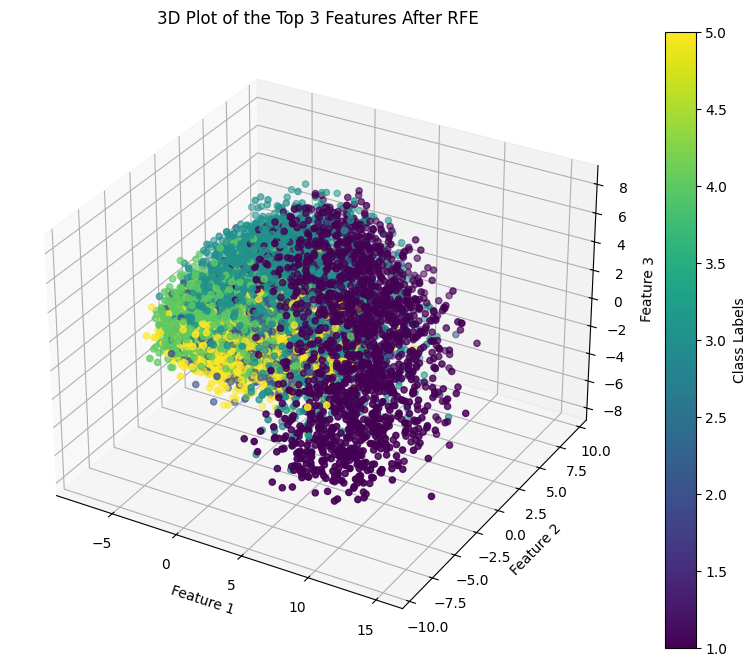

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming that the code from the previous step has already been executed
# and that I have X_selected (the data with the top 3 features from RFE)

# Plotting the data in 3D space using the top 3 features
print("Plotting the data in 3D space...")

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the first 3 columns (the top 3 features after RFE)
scatter = ax.scatter(X_selected[:, 0], X_selected[:, 1], X_selected[:, 2], c=y, cmap='viridis', marker='o')

# Adding labels to the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Adding a color bar to show the class distribution
cbar = plt.colorbar(scatter)
cbar.set_label('Class Labels')

# Title
plt.title('3D Plot of the Top 3 Features After RFE')
plt.show()


Κάνουμε νέο plot τώρα, αλλά μόνο με τα samples των κλάσεων 2, 4 και 5.

Samples excluding class 1 and class 3:
[[ 1.34435614  0.30570382 -1.47309489 ... -0.22710564 -0.33777756
  -0.43172243]
 [-2.76513106 -0.45203272 -3.85264599 ... -0.70699954 -1.03494406
  -0.41421622]
 [-3.22529519  1.5058487   0.14196465 ...  0.41774664  0.14472981
  -0.22801979]
 ...
 [-4.63737895 -4.88282505 -0.40809089 ... -0.10267688 -0.74326911
   0.38085255]
 [-2.91339883 -1.10783999  3.29955511 ...  0.52076959 -0.75478829
  -0.57465512]
 [ 0.55905196 -0.22745955  3.02442617 ...  0.06857885 -0.39647151
   0.29256934]]
Plotting the data (excluding class 1 and class 3) in 3D space...


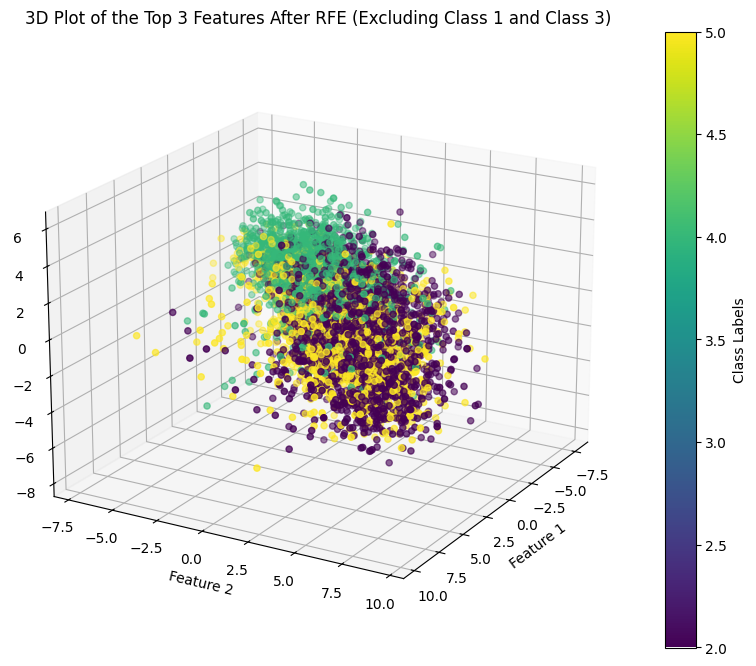

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming that the code from the previous step has already been executed
# and that you have X_selected (the data with the top 3 features after RFE)

# Filter out the samples belonging to class 1 and class 3
X_selected_excluding_classes_1_and_3 = X_selected[(y != 1) & (y != 3)]
y_excluding_classes_1_and_3 = y[(y != 1) & (y != 3)]

# Print the samples that are not from class 1 or class 3
print("Samples excluding class 1 and class 3:")
print(X_selected_excluding_classes_1_and_3)

# Plotting the data in 3D space using the top 3 features, excluding class 1 and class 3
print("Plotting the data (excluding class 1 and class 3) in 3D space...")

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the first 3 columns (the top 3 features after RFE)
scatter = ax.scatter(X_selected_excluding_classes_1_and_3[:, 0],
                     X_selected_excluding_classes_1_and_3[:, 1],
                     X_selected_excluding_classes_1_and_3[:, 2],
                     c=y_excluding_classes_1_and_3,
                     cmap='viridis', marker='o')

# Adding labels to the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Adding a color bar to show the class distribution
cbar = plt.colorbar(scatter)
cbar.set_label('Class Labels')

# Title
plt.title('3D Plot of the Top 3 Features After RFE (Excluding Class 1 and Class 3)')

# Rotate the plot interactively
ax.view_init(elev=20., azim=30)  # Set the initial angle (elev: elevation, azim: azimuthal)

plt.show()


Βλέπουμε έτσι τον λόγο για τον οποίο το μοντέλο δυσκολεύεται να διαχωρίσει αυτές τις κλάσεις (κυρίως τις 2 -μωβ- και 5 -κίτρινο- που τις μπερδεύει μεταξύ τους). Τα δείγματα της κλάσης 4 είναι λίγο πιο αποκομμένα και πιο εύκολα διαχωρίσιμα από αυτά των 2 και 5.

### SelectKbest + Mutual Information

Θα δοκιμάσουμε λοιπόν μια άλλη προσέγγιση έτσι ώστε να διαχωρίσουμε καλύτερα τις κλάσεις 2 και 5. Θα διαλέξουμε τα 150 πιο σημαντικά features (από τα 224) με βάση το mutual information χρησιμοποιώντας τον αλγόριθμο SelectKBest.

#### ***1ST VERSION***

In [ ]:
#87.29% mean cv, test 0.8685 with {C = 1.9247633984436423, gamma = 'auto'}
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from scipy import stats

#load dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

#separate features and labels
X = df.iloc[:, :-1]  #features -> all columns except for the last one
y = df.iloc[:, -1]   #labels -> last column
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#standardize features with StandardScaler (-mean & unit variance)
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

#select top 150 features using mutual information
print("Selecting top 150 features using mutual information...")
selector = SelectKBest(score_func=mutual_info_classif, k=150)
X_selected = selector.fit_transform(X_scaled, y)
print(f"Top 150 features selected. Data shape: {X_selected.shape}")

#80% train, 20% test
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

#use 2nd set of hyperparameters (from earlier)
C_opt = 1.9247633984436423
gamma_opt = 'auto'
kernel_opt = 'rbf'

#new adjusted class weights to prioritize classes 2 and 5
class_weights = {2: 5.0, 4: 1.0, 5: 7.0}  # Increased weights for classes 2 and 5 -> weight for 2: 5 and for 5: 6 or 7

#create & train svm
print("Training SVM model with adjusted class weights...")
svm_model = SVC(C=C_opt, gamma=gamma_opt, kernel=kernel_opt, class_weight=class_weights, random_state=42)
svm_model.fit(X_train, y_train)
print("Model trained successfully.")

#evaluation
print("Evaluating model...")
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with top 150 features and adjusted class weights: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

#cv accuracy with Stratified K-Fold
print("\nPerforming Stratified K-Fold Cross-validation...")
stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
print("\nStratified K-Fold Cross-validation accuracy scores (10-fold):", cv_scores)
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

#repeat 10-fold CV 5 times to show stability
cv_scores_all_runs = []
for i in range(5):
    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i) #perform stratifiedkfold with 5 different seeds for a more robust result
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
    cv_scores_all_runs.append(cv_scores)

#overall mean, standard deviation
cv_scores_flat = np.concatenate(cv_scores_all_runs)
mean_cv_score = np.mean(cv_scores_flat)
std_cv_score = np.std(cv_scores_flat)

print(f"Mean CV accuracy across all runs: {mean_cv_score:.4f}")
print(f"Standard deviation of CV accuracy across all runs: {std_cv_score:.4f}")

confidence_level = 0.95
confidence_interval = stats.t.interval(confidence_level, len(cv_scores)-1, loc=mean_cv_score, scale=std_cv_score/np.sqrt(len(cv_scores)))

print(f"Confidence Interval (95%): {confidence_interval}")


Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)
Standardizing features...
Features standardized.
Selecting top 150 features using mutual information...
Top 150 features selected. Data shape: (8743, 150)
Splitting data into training and test sets...
Training set size: 6994, Test set size: 1749
Training SVM model with adjusted class weights...
Model trained successfully.
Evaluating model...
Accuracy with top 150 features and adjusted class weights: 0.8685
Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       377
           2       0.73      0.75      0.74       332
           3       0.93      0.95      0.94       349
           4       0.93      0.90      0.91       325
           5       0.79      0.77      0.78       366

    accuracy                           0.87      1749
   macro avg       0.87      0.87      0.87      1749
weighted avg       0.87      0.87 

Στο προηγούμενο cell χρησιμοποιήσαμε βάρος 5 για την κλάση 2 και 7 για την κλάση 5, τα οποία προκύπτουν από τον παρακάτω κώδικα.

In [ ]:
#find the best class weights for the above
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#load dataset
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#select top 150 features with SelectKBest based on mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=150)
X_selected = selector.fit_transform(X_scaled, y)

#80% training, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

#base weights for classes 1,3,4
base_weights = {1: 1.0, 3: 1.0, 4: 1.0}

#possible weights for classes 2 and 5
weight_grid = [
    (5.0, 7.0), (6.0, 8.0), (7.0, 9.0), (8.0, 10.0), (9.0, 11.0), (10.0, 12.0),
    (7.0, 5.0)
]

best_accuracy = 0
best_weights = None
best_model = None

print("\nTuning class weights for classes 2 and 5...")
for w2, w5 in weight_grid:
    class_weights = base_weights.copy()
    class_weights[2] = w2
    class_weights[5] = w5

    svm_model = SVC(C=1.9247633984436423, gamma='auto', kernel='rbf', class_weight=class_weights, random_state=42)

    #cv
    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)

    #train and evaluate on test set
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Weights (2: {w2}, 5: {w5}) -> CV Accuracy: {mean_cv_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #store best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_weights = (w2, w5)
        best_model = svm_model

#final evaluation with best weights
print("\nBest Weights Found:", best_weights)
y_pred_best = best_model.predict(X_test)

print("\nClassification Report with Best Weights:")
print(classification_report(y_test, y_pred_best))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))


Tuning class weights for classes 2 and 5...
Weights (2: 5.0, 5: 7.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685
Weights (2: 6.0, 5: 8.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685
Weights (2: 7.0, 5: 9.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685
Weights (2: 8.0, 5: 10.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685
Weights (2: 9.0, 5: 11.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685
Weights (2: 10.0, 5: 12.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685
Weights (2: 7.0, 5: 5.0) -> CV Accuracy: 0.8729, Test Accuracy: 0.8685

Best Weights Found: (5.0, 7.0)

Classification Report with Best Weights:
              precision    recall  f1-score   support

           1       0.95      0.98      0.96       377
           2       0.73      0.75      0.74       332
           3       0.93      0.95      0.94       349
           4       0.93      0.90      0.91       325
           5       0.79      0.77      0.78       366

    accuracy                           0.87      1749


Με αυτές τις αλλαγές, ξανακάνουμε hyperparameter tuning (αυτή τη φορά με GridSearchCV) και προκύπτει το 3ο σετ υπερπαραμέτρων.

##### 3rd set of hyperparameters
{'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
#tuning again -> test 0.8725 {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#standardize
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

#top 150 features using mutual information
print("Selecting top 150 features using mutual information...")
selector = SelectKBest(score_func=mutual_info_classif, k=150)
X_selected = selector.fit_transform(X_scaled, y)
print(f"Top 150 features selected. Data shape: {X_selected.shape}")

#80% train, 20% test
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

#hyperparameter tuning using GridSearchCV
print("Starting hyperparameter tuning using GridSearchCV...")

svm_model = SVC(class_weight={2: 5.0, 4: 1.0, 5: 7.0}, random_state=42)

#parameter grid
param_grid = {
    'C': [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2],     #regularization strength
    'gamma': ['scale', 'auto', 0.01, 0.1],    #kernel
    'kernel': ['rbf']
}

#stratified K-Fold CV, K=5
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                           scoring='accuracy', cv=stratified_kf, verbose=1, n_jobs=-1)

#fit model with GridSearch
grid_search.fit(X_train, y_train)

#best hyperparameters and score
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#train best model
best_model = grid_search.best_estimator_
print("\nTraining the best model on the training set...")
best_model.fit(X_train, y_train)

#evaluation on test set
print("\nEvaluating the best model on the test set...")
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)
Standardizing features...
Features standardized.
Selecting top 150 features using mutual information...
Top 150 features selected. Data shape: (8743, 150)
Splitting data into training and test sets...
Training set size: 6994, Test set size: 1749
Starting hyperparameter tuning using GridSearchCV...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best parameters found: {'C': 2, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8730

Training the best model on the training set...

Evaluating the best model on the test set...
Test set accuracy: 0.8725
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       377
           2       0.74      0.74      0.74       332
           3       0.94      0.95      0.94       349
           4       0.93      0.90      0.92       325
           5       0.7

#### Separate features for classes 2 and 5 approach

Για να διαχωρίσουμε καλύτερα τις κλάσεις 2 και 5, εκτός από τα top 150 global features με βάση το mutual information, ας διαλέξουμε και έξτρα κάποια class-specific features των κλάσεων 2 και 5, πάλι με βάση το mutual information. Μετά από δοκιμές και ελέγχους αποφασίζουμε να κρατήσουμε τα top 50 class-specific features.


##### ***2ND VERSION***
{C=2.1946408926552823 , gamma=0.01} + top 50 class-specific features

In [ ]:
#test 88.45%, mean cv 86.92% with {C=2.1946408926552823 , gamma=0.01}
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)  # Adjust the path as needed
print("Dataset loaded successfully!")

# Separate features and labels
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Labels
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

# Standardize the features (important for SVM)
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

# Step 1: Select top 150 features globally using mutual information
print("\nSelecting top 150 features globally using mutual information...")
selector_global = SelectKBest(score_func=mutual_info_classif, k=150)
X_selected_global = selector_global.fit_transform(X_scaled, y)
global_feature_indices = selector_global.get_support(indices=True)
print(f"Global feature indices: {len(global_feature_indices)} features selected.")

# Step 2: Perform class-specific feature selection for classes 2 and 5
print("\nPerforming class-specific feature selection for classes 2 and 5...")
subset_mask = (y == 2) | (y == 5)
X_2_5 = X_scaled[subset_mask]
y_2_5 = y[subset_mask]

# Compute mutual information scores for class 2 vs 5
mi_scores_2_5 = mutual_info_classif(X_2_5, y_2_5, random_state=42)

# Select top 50 features for class 2 vs 5 (subset)
n_class_specific = 50
selected_indices_2_5 = np.argsort(mi_scores_2_5)[-n_class_specific:]
print(f"Class-specific feature indices: {len(selected_indices_2_5)} features selected for classes 2 and 5.")

# Combine global and a subset of class-specific features (unique)
refined_combined_feature_indices = np.unique(np.concatenate((global_feature_indices, selected_indices_2_5)))
X_refined_combined = X_scaled[:, refined_combined_feature_indices]
print(f"Refined combined feature set shape: {X_refined_combined.shape}")

# Step 3: Split the data into training and test sets (80% train, 20% test)
print("\nSplitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_refined_combined, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Adjusted class weights to prioritize classes 2 and 5
class_weights = {2: 5.0, 4: 1.0, 5: 7.0}

# Create and train the SVM model
C_opt_refined = 2.1946408926552823  # Regularization parameter
print("\nTraining SVM model with combined features and adjusted class weights...")
svm_model = SVC(C=C_opt_refined, gamma=0.01, kernel='rbf', class_weight=class_weights, random_state=42)
svm_model.fit(X_train, y_train)
print("Model trained successfully.")

# Step 4: Evaluate the model
print("\nEvaluating model...")
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with refined combined features and adjusted class weights: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

# Cross-validation accuracy using Stratified K-Fold
print("\nPerforming Stratified K-Fold Cross-validation...")
stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
print("\nStratified K-Fold Cross-validation accuracy scores (10-fold):", cv_scores)
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)
confidence_level = 0.95
confidence_interval = stats.t.interval(confidence_level, len(cv_scores)-1, loc=mean_cv_score, scale=std_cv_score/np.sqrt(len(cv_scores)))
print(f"Confidence Interval (95%): {confidence_interval}")


Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)
Standardizing features...
Features standardized.

Selecting top 150 features globally using mutual information...
Global feature indices: 150 features selected.

Performing class-specific feature selection for classes 2 and 5...
Class-specific feature indices: 50 features selected for classes 2 and 5.
Refined combined feature set shape: (8743, 154)

Splitting data into training and test sets...
Training set size: 6994, Test set size: 1749

Training SVM model with combined features and adjusted class weights...
Model trained successfully.

Evaluating model...
Accuracy with refined combined features and adjusted class weights: 0.8879
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       354
           2       0.80      0.76      0.78       344
           3       0.94      0.96      0.95       351
           4       0.

Καταλήγουμε λοιπόν στο μοντέλο με τον καλύτερο συνδυασμό υπερπαραμέτρων και την καλύτερη απόδοση.

#### BEST SINGLE SVM APPROACH
{C = 1.9247633984436423, gamma=0.01} + top 150 global + top 25 class-specific features

In [ ]:
#test 0.8908, mean cv 0.8703
#Mean CV accuracy across all runs: 0.8693
#Standard deviation of CV accuracy across all runs: 0.0105
#95% Confidence Interval for CV accuracy: (0.8663119374183037, 0.8722651318643453)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats

#load dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels -> last column
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#standardize
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

#select top 150 features globally (all classes) using mutual information
print("\nSelecting top 150 features globally using mutual information...")
selector_global = SelectKBest(score_func=mutual_info_classif, k=150)
X_selected_global = selector_global.fit_transform(X_scaled, y)
global_feature_indices = selector_global.get_support(indices=True)
print(f"Global feature indices: {len(global_feature_indices)} features selected.")

#class-specific feature selection for classes 2 and 5
print("\nPerforming class-specific feature selection for classes 2 and 5...")
subset_mask = (y == 2) | (y == 5)
X_2_5 = X_scaled[subset_mask]
y_2_5 = y[subset_mask]
#mutual information scores for class 2 vs 5
mi_scores_2_5 = mutual_info_classif(X_2_5, y_2_5, random_state=42)
#select top 25 features for class 2 vs 5 (subset)
n_class_specific = 25
selected_indices_2_5 = np.argsort(mi_scores_2_5)[-n_class_specific:]
print(f"Class-specific feature indices: {len(selected_indices_2_5)} features selected for classes 2 and 5.")

#combine global and subset of class-specific features (unique)
refined_combined_feature_indices = np.unique(np.concatenate((global_feature_indices, selected_indices_2_5)))
X_refined_combined = X_scaled[:, refined_combined_feature_indices]
print(f"Refined combined feature set shape: {X_refined_combined.shape}")

#80% train, 20% test
print("\nSplitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_refined_combined, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

#custom class weights (focus on classes 2 and 5)
class_weights = {2: 5.0, 4: 1.0, 5: 7.0}

#train svm model
C_opt_refined = 1.9247633984436423 #regularization parameter
print("\nTraining SVM model with combined features and adjusted class weights...")
svm_model = SVC(C=C_opt_refined, gamma=0.01, kernel='rbf', class_weight=class_weights, random_state=42)
svm_model.fit(X_train, y_train)
print("Model trained successfully.")

#evaluation
print("\nEvaluating model...")
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with refined combined features and adjusted class weights: {accuracy:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

#cv accuracy with Stratified K-Fold
print("\nPerforming Stratified K-Fold Cross-validation...")
stratified_kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
print("\nStratified K-Fold Cross-validation accuracy scores (20-fold):", cv_scores)
print(f"Mean cross-validation accuracy: {np.mean(cv_scores):.4f}")

#print("Test set class distribution:", np.bincount(y_test.astype(int)))

#repeat 10-fold CV 5 times
cv_scores_all_runs = []
for i in range(5):
    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
    cv_scores_all_runs.append(cv_scores)

#overall mean & standard deviation of all 5 runs
cv_scores_flat = np.concatenate(cv_scores_all_runs)
mean_cv_score = np.mean(cv_scores_flat)
std_cv_score = np.std(cv_scores_flat)

print(f"Mean CV accuracy across all runs: {mean_cv_score:.4f}")
print(f"Standard deviation of CV accuracy across all runs: {std_cv_score:.4f}")


confidence_level = 0.95
n = len(cv_scores_flat)  #number of CV scores across all runs -> 5

#find confidence interval
confidence_interval = stats.t.interval(
    confidence_level,
    df=n-1,  # Degrees of freedom
    loc=mean_cv_score,
    scale=std_cv_score / np.sqrt(n)
)

print(f"95% Confidence Interval for CV accuracy: {confidence_interval}")

Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)
Standardizing features...
Features standardized.

Selecting top 150 features globally using mutual information...
Global feature indices: 150 features selected.

Performing class-specific feature selection for classes 2 and 5...
Class-specific feature indices: 25 features selected for classes 2 and 5.
Refined combined feature set shape: (8743, 150)

Splitting data into training and test sets...
Training set size: 6994, Test set size: 1749

Training SVM model with combined features and adjusted class weights...
Model trained successfully.

Evaluating model...
Accuracy with refined combined features and adjusted class weights: 0.8908
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.99      0.98       354
           2       0.81      0.76      0.78       344
           3       0.94      0.96      0.95       351
           4       0.

Στον παραπάνω κώδικα επιλέγουμε τα top 150  global features με βάση το mutual information όλων των κλάσεων και μετά τα 25 top features για τις κλάσεις 2 και 5. Επιλέγουμε αυτόν τον συνδυασμό έπειτα από το αποτέλεσμα του παρακάτω cell.

In [ ]:
#check best combination of number of global features and class-specific features again
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score
from scipy import stats

print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

X = df.iloc[:, :-1]  # features
y = df.iloc[:, -1]   # labels -> last column
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#standardize
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

best_combination = None
best_mean_cv_accuracy = 0
best_std_cv_accuracy = 0
best_confidence_interval = (0, 0)

for n_global in [100, 150, 200]:
    for n_class_specific in [25, 50, 100, 150]:
        print(f"\nEvaluating combination: {n_global} global features, {n_class_specific} class-specific features")

        #select top n_global features globally
        selector_global = SelectKBest(score_func=mutual_info_classif, k=n_global)
        X_selected_global = selector_global.fit_transform(X_scaled, y)
        global_feature_indices = selector_global.get_support(indices=True)

        #class-specific feature selection for classes 2 and 5
        subset_mask = (y == 2) | (y == 5)
        X_2_5 = X_scaled[subset_mask]
        y_2_5 = y[subset_mask]
        mi_scores_2_5 = mutual_info_classif(X_2_5, y_2_5, random_state=42)
        selected_indices_2_5 = np.argsort(mi_scores_2_5)[-n_class_specific:]

        #combine global and class-specific features
        refined_combined_feature_indices = np.unique(np.concatenate((global_feature_indices, selected_indices_2_5)))
        X_refined_combined = X_scaled[:, refined_combined_feature_indices]

        X_train, X_test, y_train, y_test = train_test_split(
            X_refined_combined, y, test_size=0.2, random_state=42, stratify=y
        )

        #custom class weights
        class_weights = {2: 5.0, 4: 1.0, 5: 7.0}

        #train SVM model
        svm_model = SVC(C=1.9247633984436423, gamma=0.01, kernel='rbf', class_weight=class_weights, random_state=42)
        svm_model.fit(X_train, y_train)

        #10-fold cross-validation 5 times
        cv_scores_all_runs = []
        for i in range(5):
            stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
            cv_scores = cross_val_score(svm_model, X_train, y_train, cv=stratified_kf, scoring='accuracy')
            cv_scores_all_runs.append(cv_scores)

        #find mean, standard deviation and confidence interval
        cv_scores_flat = np.concatenate(cv_scores_all_runs)
        mean_cv_score = np.mean(cv_scores_flat)
        std_cv_score = np.std(cv_scores_flat)

        confidence_interval = stats.t.interval(
            0.95,
            df=len(cv_scores_flat) - 1,
            loc=mean_cv_score,
            scale=std_cv_score / np.sqrt(len(cv_scores_flat))
        )

        print(f"Mean CV accuracy: {mean_cv_score:.4f}, Std: {std_cv_score:.4f}, 95% CI: {confidence_interval}")

        if mean_cv_score > best_mean_cv_accuracy:
            best_combination = (n_global, n_class_specific)
            best_mean_cv_accuracy = mean_cv_score
            best_std_cv_accuracy = std_cv_score
            best_confidence_interval = confidence_interval

#print the best combination and results
print("\nBest combination:")
print(f"Global features: {best_combination[0]}, Class-specific features: {best_combination[1]}")
print(f"Best mean CV accuracy: {best_mean_cv_accuracy:.4f}, Std: {best_std_cv_accuracy:.4f}")
print(f"Best 95% CI: {best_confidence_interval}")


Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)
Standardizing features...
Features standardized.

Evaluating combination: 100 global features, 25 class-specific features
Mean CV accuracy: 0.8423, Std: 0.0111, 95% CI: (0.8391754056951474, 0.8454727038491)

Evaluating combination: 100 global features, 50 class-specific features
Mean CV accuracy: 0.8472, Std: 0.0115, 95% CI: (0.8439783964740186, 0.8505076039347281)

Evaluating combination: 100 global features, 100 class-specific features
Mean CV accuracy: 0.8541, Std: 0.0107, 95% CI: (0.8510812890047564, 0.8571846419169685)

Evaluating combination: 100 global features, 150 class-specific features
Mean CV accuracy: 0.8562, Std: 0.0104, 95% CI: (0.853258986986968, 0.8591842584657197)

Evaluating combination: 150 global features, 25 class-specific features
Mean CV accuracy: 0.8693, Std: 0.0105, 95% CI: (0.8663119374183037, 0.8722651318643453)

Evaluating combination: 150 global features, 50 

KeyboardInterrupt: 

Παρακάτω ακολουθεί κώδικας για εκπαίδευση του single-SVM μοντέλου με ολόκληρο το datasetTV.csv και εξαγωγή των labels από το datasetTest.csv (για σύγκριση με τα αποτελέσματα που θα βγάλει το τελικό μας multi-SVM μοντέλο - όντως διαφέρουν σε περίπου 400 predictions, τα περισσότερα από αυτά να είναι για τις κλάσεις 2 και 5).

In [ ]:
#SINGLE svm approach
#train SVM on the entire dataset using refined combined features
print("\nTraining SVM model on the entire dataset with combined features and adjusted class weights...")
svm_model_full_data = SVC(C=C_opt_refined, gamma='auto', kernel='rbf', class_weight=class_weights, random_state=42)
svm_model_full_data.fit(X_refined_combined, y)
print("Model trained successfully on the entire dataset.")



Training SVM model on the entire dataset with combined features and adjusted class weights...
Model trained successfully on the entire dataset.


In [ ]:
#SINGLE svm approach
#load test set
print("Loading test dataset...")
df_test = pd.read_csv('/content/drive/MyDrive/datasetTest.csv', header=None)
print("Test dataset loaded successfully!")

#extract features (no labels in test data)
X_test_data = df_test.iloc[:, :]  #all columns are features

#standardize test data using the same scaler as the training data
print("Standardizing test features...")
X_test_scaled = scaler.transform(X_test_data)
print("Test features standardized.")

#select the same refined features as in training
X_test_refined_combined = X_test_scaled[:, refined_combined_feature_indices]
print(f"Test dataset after feature selection has shape: {X_test_refined_combined.shape}")

#predict labels using the fully trained SVM model
print("Predicting labels for the test dataset...")
labels10 = svm_model_full_data.predict(X_test_refined_combined)
print(f"Labels predicted successfully. Number of predictions: {len(labels10)}")

#convert labels to numpy array
labels10 = np.array(labels10)
print(f"Labels converted to numpy array. Shape: {labels10.shape}")

print("Predicted labels:", labels10[:10])  #first 10 predictions

output_path = '/content/drive/MyDrive/labels10-SINGLE.npy'
np.save(output_path, labels10)
print(f"Predicted labels saved to {output_path}.")

Loading test dataset...
Test dataset loaded successfully!
Standardizing test features...
Test features standardized.
Test dataset after feature selection has shape: (6955, 150)
Predicting labels for the test dataset...
Labels predicted successfully. Number of predictions: 6955
Labels converted to numpy array. Shape: (6955,)
Predicted labels: [1 4 5 2 5 4 2 2 1 3]
Predicted labels saved to /content/drive/MyDrive/labels10.npy.


# **Τελική προσέγγιση (Ensemble of 5 SVMs):**

Αντί για ένα single-SVM μοντέλο με custom class weights και class-specific feature selection ας δοκιμάσουμε ένα multi-SVM μοντέλο (ensemble of 5 SVMs) με ένα SVM τύπου One-vs-Rest (ή One-vs-All) για κάθε κλάση όπου καθένα από αυτά θα έχει διαφορετικό regularization parameter C για καλύτερο διαχωρισμό των κλάσεων.
Από τις προηγούμενες δοκιμές με μοντέλα που κάναμε αποφασίζουμε εδώ να χρησιμοποιήσουμε υπερπαραμέτρους gamma=0.01 και kernel='rbf' για κάθε SVM.

## BEST MULTI-SVM APPROACH + 150 global

In [ ]:
#Test Set Accuracy: 0.8937
#Mean Accuracy: 0.8752
#Standard Deviation of Accuracy: 0.0091
#95% CI: (0.8639, 0.8865)
#Mean cv accuracy of 5 5-fold runs with different seeds: 87.5252%

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy import stats

#load dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels -> last column
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#feature selection -> 150 top features based on mutual information
print("\nSelecting 150 global features using mutual information...")
global_selector = SelectKBest(mutual_info_classif, k=150)
X_global_selected = global_selector.fit_transform(X, y)
print(f"Global feature-selected shape: {X_global_selected.shape}")

#standardize features
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_global_selected)
print("Features standardized.")

# # Define class-specific C values
# class_specific_C = {
#     1: 1.0,
#     2: 2.0,
#     3: 1.5,
#     4: 1.2,
#     5: 3.0
# }

# Define class-specific C values -> values after tuning (below)
class_specific_C = {
    1: 1.262945498073723,
    2: 1.7207533426024557,
    3: 1.3773691548653184,
    4: 2.14167412103877,
    5: 3.5250337597457726
}

#80%-20% train-test split
print("\nSplitting data into 80% training and 20% test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

#train 1 SVM model for each class
print("\nTraining separate SVM models on the training set...")
svm_models = {}
for cls in class_specific_C.keys():
    svm = SVC(C=class_specific_C[cls], gamma=0.01, kernel='rbf', probability=True, random_state=42)
    y_train_binary = (y_train == cls).astype(int)  # One-vs-All
    svm.fit(X_train, y_train_binary)
    svm_models[cls] = svm

#predictions for test set
print("\nCombining predictions from all models for the test set...")
test_probabilities = []
#for each class (cls) the model computes the probability that a given sample belongs to that class (platt scaling)
for cls, svm in svm_models.items():
    prob = svm.predict_proba(X_test)[:, 1]  #probability of being in class cls
    test_probabilities.append(prob)

#combine predictions by selecting the class with the highest probability
test_probabilities = np.array(test_probabilities)  #shape: (num_classes, num_samples)
test_predictions = np.argmax(test_probabilities, axis=0) + 1  #classes are 1-indexed

#evaluate performance on test set
test_accuracy = accuracy_score(y_test, test_predictions)
print("\nEvaluation on Test Set:")
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print("Classification Report (Test Set):")
print(classification_report(y_test, test_predictions))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, test_predictions))

#StratifiedKFold cv with 5 folds
print("\nPerforming Stratified K-Fold Cross-validation with k=5...")
k_folds = 5
stratified_kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_accuracies = []
fold_classification_reports = []
fold_confusion_matrices = []

for fold_idx, (train_index, test_index) in enumerate(stratified_kf.split(X_scaled, y), start=1):
    print(f"\nProcessing fold {fold_idx}...")

    #split the data into training and testing for this fold
    X_fold_train, X_fold_test = X_scaled[train_index], X_scaled[test_index]
    y_fold_train, y_fold_test = y[train_index], y[test_index]

    #train separate SVM models for each class
    print("Training separate SVM models for each class...")
    fold_svm_models = {}
    for cls in class_specific_C.keys():
        svm = SVC(C=class_specific_C[cls], gamma=0.01, kernel='rbf', probability=True, random_state=42)
        y_fold_train_binary = (y_fold_train == cls).astype(int)  #one-v-all -> creates a binary label where the current class cls is set to 1 and all other classes are set to 0
        svm.fit(X_fold_train, y_fold_train_binary)
        fold_svm_models[cls] = svm

    #make predictions for each class
    print("Combining predictions from all models...")
    fold_probabilities = []
    for cls, svm in fold_svm_models.items():
        prob = svm.predict_proba(X_fold_test)[:, 1]  #probability of being in class `cls`
        fold_probabilities.append(prob)

    #combine predictions by selecting the class with the highest probability
    fold_probabilities = np.array(fold_probabilities)  #shape: (num_classes, num_samples)
    fold_predictions = np.argmax(fold_probabilities, axis=0) + 1  #classes are 1-indexed

    #evaluate the combined predictions for this fold
    accuracy = accuracy_score(y_fold_test, fold_predictions)
    fold_accuracies.append(accuracy)
    fold_classification_reports.append(classification_report(y_fold_test, fold_predictions, output_dict=True))
    fold_confusion_matrices.append(confusion_matrix(y_fold_test, fold_predictions))

    print(f"Fold {fold_idx} Accuracy: {accuracy:.4f}")

#overall cv performance
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print("\nCross-validation results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

n_folds = len(fold_accuracies)

# 95% confidence interval
confidence = 0.95
ci_low, ci_high = stats.t.interval(
    confidence,
    df=n_folds-1,
    loc=mean_accuracy,
    scale=std_accuracy / np.sqrt(n_folds)
)

print("\n95% Confidence Interval for Cross-Validation Accuracy:")
print(f"95% CI: ({ci_low:.4f}, {ci_high:.4f})")


# mean cv accuracy of commented out code (5 5-fold cv with different seeds): 87.5252%

# for i in range(5):
#   for fold_idx, (train_index, test_index) in enumerate(stratified_kf.split(X_scaled, y), start=1):
#       print(f"\nProcessing fold {fold_idx}...")

#       #split the data into training and testing for this fold
#       X_fold_train, X_fold_test = X_scaled[train_index], X_scaled[test_index]
#       y_fold_train, y_fold_test = y[train_index], y[test_index]

#       #train separate SVM models for each class
#       print("Training separate SVM models for each class...")
#       fold_svm_models = {}
#       for cls in class_specific_C.keys():
#           svm = SVC(C=class_specific_C[cls], gamma=0.01, kernel='rbf', probability=True, random_state=i)
#           y_fold_train_binary = (y_fold_train == cls).astype(int)  #one-v-all -> creates a binary label where the current class cls is set to 1 and all other classes are set to 0
#           svm.fit(X_fold_train, y_fold_train_binary)
#           fold_svm_models[cls] = svm

#       #make predictions for each class
#       print("Combining predictions from all models...")
#       fold_probabilities = []
#       for cls, svm in fold_svm_models.items():
#           prob = svm.predict_proba(X_fold_test)[:, 1]  #probability of being in class `cls`
#           fold_probabilities.append(prob)

#       #combine predictions by selecting the class with the highest probability
#       fold_probabilities = np.array(fold_probabilities)  #shape: (num_classes, num_samples)
#       fold_predictions = np.argmax(fold_probabilities, axis=0) + 1  #classes are 1-indexed

#       #evaluate the combined predictions for this fold
#       accuracy = accuracy_score(y_fold_test, fold_predictions)
#       fold_accuracies.append(accuracy)
#       fold_classification_reports.append(classification_report(y_fold_test, fold_predictions, output_dict=True))
#       fold_confusion_matrices.append(confusion_matrix(y_fold_test, fold_predictions))

#       print(f"Fold {fold_idx} Accuracy: {accuracy:.4f}")






Loading dataset...
Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)

Selecting 150 global features using mutual information...
Global feature-selected shape: (8743, 150)

Standardizing features...
Features standardized.

Splitting data into 80% training and 20% test sets...
Training set size: 6994, Test set size: 1749

Training separate SVM models on the training set...

Combining predictions from all models for the test set...

Evaluation on Test Set:
Test Set Accuracy: 0.8937
Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.98      0.97      0.98       354
           2       0.83      0.76      0.80       344
           3       0.92      0.96      0.94       351
           4       0.94      0.93      0.93       343
           5       0.80      0.84      0.82       357

    accuracy                           0.89      1749
   macro avg       0.89      0.89      0.89      1749
weighted avg      

Οι τιμές των C των SVMs για κάθε κλάση υπολογίστηκαν μέσω Bayesian Optimization με τον παρακάτω κώδικα.

## MULTI-SVM APPROACH C tuning

In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#load dataset
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/datasetTV.csv', header=None)
print("Dataset loaded successfully!")

X = df.iloc[:, :-1]  #features
y = df.iloc[:, -1]   #labels -> last column
print(f"Features shape: {X.shape}, Labels shape: {y.shape}")

#standardize features
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features standardized.")

# 80%-20% Train-Test Split
print("\nSplitting data into 80% training and 20% test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

#objective function for Optuna
def objective(trial, X_train, y_train, X_test, y_test, class_idx):
    """
    The objective function that Optuna will use to optimize the hyperparameters.
    """
    #C values to try (between 1e-5 and 1e2 -log scale-)
    C = trial.suggest_loguniform('C', 1e-5, 1e2)

    #SVM model with suggested C
    svm = SVC(C=C, gamma=0.01, kernel='rbf', probability=True, random_state=42)

    #one-v-all for class-specific binary labels
    y_train_binary = (y_train == class_idx).astype(int)

    #train model
    svm.fit(X_train, y_train_binary)

    #predictions on test set
    y_pred = svm.predict(X_test)

    #accuracy
    accuracy = accuracy_score((y_test == class_idx).astype(int), y_pred)

    return accuracy  #return accuracy (optimization objective)

svm_models = {}
best_C_values = {}

#tuning for each class
for class_idx in range(1, 6):  #class labels from 1 to 5
    print(f"\nTuning C for class {class_idx}...")

    #create Optuna study for this class
    study = optuna.create_study(direction='maximize')

    #optimize objective function
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test, class_idx), n_trials=50) #perform 50 trials

    #get the best C value for this class
    best_C = study.best_params['C']
    best_C_values[class_idx] = best_C

    #create final model with the best C value
    final_svm = SVC(C=best_C, gamma=0.01, kernel='rbf', probability=True, random_state=42)
    svm_models[class_idx] = final_svm

    print(f"Best C for class {class_idx}: {best_C}")

#train final models on the full training set for each class
for class_idx, svm in svm_models.items():
    y_train_binary = (y_train == class_idx).astype(int)  #one-v-all
    svm.fit(X_train, y_train_binary)

#predictions for test set
print("\nCombining predictions from all models for the test set...")
test_probabilities = []
for class_idx, svm in svm_models.items():
    prob = svm.predict_proba(X_test)[:, 1]  #probability of being in class class_idx
    test_probabilities.append(prob)

#combine predictions by selecting the class with the highest probability
test_probabilities = np.array(test_probabilities)  #shape: (num_classes, num_samples)
test_predictions = np.argmax(test_probabilities, axis=0) + 1  #classes are 1-indexed

#performance evaluation on test set
test_accuracy = accuracy_score(y_test, test_predictions)
print("\nEvaluation on Test Set:")
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print("Classification Report (Test Set):")
print(classification_report(y_test, test_predictions))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, test_predictions))

#StratifiedKFold cv
print("\nPerforming Stratified K-Fold Cross-validation with k=5...")
k_folds = 5
stratified_kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_accuracies = []
fold_classification_reports = []
fold_confusion_matrices = []

#cross validation
for fold_idx, (train_index, test_index) in enumerate(stratified_kf.split(X_scaled, y), start=1):
    print(f"\nProcessing fold {fold_idx}...")

    #split data into training and testing for this fold
    X_fold_train, X_fold_test = X_scaled[train_index], X_scaled[test_index]
    y_fold_train, y_fold_test = y[train_index], y[test_index]

    #train separate SVM models for each class with Optuna-tuned C values
    print("Training separate SVM models for each class...")
    fold_svm_models = {}
    for class_idx in range(1, 6):
        final_svm = svm_models[class_idx]  # Use the best C value from Optuna
        y_fold_train_binary = (y_fold_train == class_idx).astype(int)
        final_svm.fit(X_fold_train, y_fold_train_binary)
        fold_svm_models[class_idx] = final_svm

    #make predictions for each class
    print("Combining predictions from all models...")
    fold_probabilities = []
    for class_idx, svm in fold_svm_models.items():
        prob = svm.predict_proba(X_fold_test)[:, 1]  #probability of being in class `class_idx`
        fold_probabilities.append(prob)

    #combine predictions by selecting the class with the highest probability
    fold_probabilities = np.array(fold_probabilities)  #shape: (num_classes, num_samples)
    fold_predictions = np.argmax(fold_probabilities, axis=0) + 1  #classes are 1-indexed

    #evaluation of combined predictions for this fold
    accuracy = accuracy_score(y_fold_test, fold_predictions)
    fold_accuracies.append(accuracy)
    fold_classification_reports.append(classification_report(y_fold_test, fold_predictions, output_dict=True))
    fold_confusion_matrices.append(confusion_matrix(y_fold_test, fold_predictions))

    print(f"Fold {fold_idx} Accuracy: {accuracy:.4f}")

#overall cv performance
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print("\nCross-validation results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

#classification report and confusion matrices for each fold
print("\nFold-by-fold Classification Reports and Confusion Matrices:")
for fold_idx, (report, matrix) in enumerate(zip(fold_classification_reports, fold_confusion_matrices), start=1):
    print(f"\nFold {fold_idx} Classification Report:")
    print(pd.DataFrame(report).transpose())
    print(f"Fold {fold_idx} Confusion Matrix:")
    print(matrix)


Loading dataset...


[I 2025-01-05 22:20:02,516] A new study created in memory with name: no-name-4b1ba04a-e3cf-48c3-a1d0-c36990567d8e


Dataset loaded successfully!
Features shape: (8743, 224), Labels shape: (8743,)

Standardizing features...
Features standardized.

Splitting data into 80% training and 20% test sets...
Training set size: 6994, Test set size: 1749

Tuning C for class 1...


<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 2025-01-05 22:20:55,828] Trial 0 finished with value: 0.7975986277873071 and parameters: {'C': 0.01748327990658756}. Best is trial 0 with value: 0.7975986277873071.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 2025-01-05 22:21:19,972] Trial 1 finished with value: 0.7975986277873071 and parameters: {'C': 0.03189654105747184}. Best is trial 0 with value: 0.7975986277873071

Best C for class 1: 90.27117037589284

Tuning C for class 2...


[I 2025-01-05 22:40:18,073] Trial 0 finished with value: 0.8987993138936535 and parameters: {'C': 44.87293940747829}. Best is trial 0 with value: 0.8987993138936535.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 2025-01-05 22:41:23,111] Trial 1 finished with value: 0.8987993138936535 and parameters: {'C': 4.313545481646}. Best is trial 0 with value: 0.8987993138936535.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 20

Best C for class 2: 1.7207533426024557

Tuning C for class 3...


[I 2025-01-05 23:17:35,109] Trial 0 finished with value: 0.7993138936535163 and parameters: {'C': 0.01699401517463742}. Best is trial 0 with value: 0.7993138936535163.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 2025-01-05 23:18:07,210] Trial 1 finished with value: 0.7993138936535163 and parameters: {'C': 0.0009126121759472985}. Best is trial 0 with value: 0.7993138936535163.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log sca

Best C for class 3: 10.899461396638626

Tuning C for class 4...


[I 2025-01-05 23:48:33,583] Trial 0 finished with value: 0.8038879359634077 and parameters: {'C': 2.3172323155239836e-05}. Best is trial 0 with value: 0.8038879359634077.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 2025-01-05 23:48:55,511] Trial 1 finished with value: 0.8038879359634077 and parameters: {'C': 1.3351867000691616e-05}. Best is trial 0 with value: 0.8038879359634077.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log

Best C for class 4: 81.43570806750832

Tuning C for class 5...


[I 2025-01-06 00:19:54,295] Trial 0 finished with value: 0.7958833619210978 and parameters: {'C': 1.589455879196133e-05}. Best is trial 0 with value: 0.7958833619210978.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log scale)
[I 2025-01-06 00:20:18,300] Trial 1 finished with value: 0.7958833619210978 and parameters: {'C': 0.0001942245761290304}. Best is trial 0 with value: 0.7958833619210978.
<ipython-input-15-41598eb6ba6a>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e2)  # C values between 1e-5 and 1e2 (log s

Best C for class 5: 8.164185048132092

Combining predictions from all models for the test set...

Evaluation on Test Set:
Test Set Accuracy: 0.8628
Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.95      0.97      0.96       354
           2       0.78      0.71      0.74       344
           3       0.91      0.93      0.92       351
           4       0.92      0.91      0.91       343
           5       0.76      0.79      0.77       357

    accuracy                           0.86      1749
   macro avg       0.86      0.86      0.86      1749
weighted avg       0.86      0.86      0.86      1749

Confusion Matrix (Test Set):
[[343   2   6   3   0]
 [  1 244  11   7  81]
 [ 11   3 328   8   1]
 [  2   8  12 313   8]
 [  4  57   4  11 281]]

Performing Stratified K-Fold Cross-validation with k=5...

Processing fold 1...
Training separate SVM models for each class...
Combining predictions from all models...
Fold 1 Accuracy

Αποτελέσματα από C tuning:

Class 1: accuracy 0.9839908519153803 with {'C': 1.262945498073723}

Class 2: accuracy 0.89937106918239 with: {'C': 1.7207533426024557}

Class 3: accuracy 0.9536878216123499 with: {'C': 1.3773691548653184} or {'C': 2.7421488153746916}

Class 4: accuracy 0.9599771297884505 with: {'C': 2.14167412103877}

Class 5: accuracy 0.8930817610062893 with: {'C': 3.5250337597457726}
         

## TRAIN WITH ALL DATA

In [ ]:
#MULTI-svm approach
#train SVM models on the entire dataset
print("\nTraining separate SVM models on the entire dataset...")

#dictionary to store trained SVM models
svm_models_full_data = {}

#train 1 SVM model per class
for cls in class_specific_C.keys():
    print(f"Training SVM model for class {cls}...")
    svm = SVC(C=class_specific_C[cls], gamma=0.01, kernel='rbf', probability=True, random_state=42)
    y_binary = (y == cls).astype(int)  # One-vs-All labels for current class
    svm.fit(X_scaled, y_binary)
    svm_models_full_data[cls] = svm
    print(f"SVM model for class {cls} trained successfully.")

print("All SVM models trained on the entire dataset.")



Training separate SVM models on the entire dataset...
Training SVM model for class 1...
SVM model for class 1 trained successfully.
Training SVM model for class 2...
SVM model for class 2 trained successfully.
Training SVM model for class 3...
SVM model for class 3 trained successfully.
Training SVM model for class 4...
SVM model for class 4 trained successfully.
Training SVM model for class 5...
SVM model for class 5 trained successfully.
All SVM models trained on the entire dataset.


## EXPORT LABELS

In [ ]:
#MULTI-svm approach
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm import SVC

#load test set
print("Loading test dataset...")
df_test = pd.read_csv('/content/drive/MyDrive/datasetTest.csv', header=None)
print("Test dataset loaded successfully!")

X_test_data = df_test.iloc[:, :]  #extract features (no labels)

#feature selection using the same global selector as in the training data
print("\nSelecting 150 global features using mutual information (same as training data)...")
X_test_selected = global_selector.transform(X_test_data)
print(f"Test data after feature selection shape: {X_test_selected.shape}")

#standardize features (apply the same standardization -same scaler- as in training)
print("\nStandardizing test features using the same scaler as the training data...")
X_test_scaled = scaler.transform(X_test_selected)
print("Test features standardized.")

#use the trained SVM models to predict the labels for the test set
print("\nPredicting labels using the trained SVM models...")
test_probabilities = []
for cls, svm in svm_models_full_data.items():
    prob = svm.predict_proba(X_test_scaled)[:, 1]  #probability of being in class cls (platt scaling)
    test_probabilities.append(prob)

#combine predictions by selecting the class with the highest probability
test_probabilities = np.array(test_probabilities)  #shape: (num_classes, num_samples)
test_predictions = np.argmax(test_probabilities, axis=0) + 1  #classes are 1-indexed

print(f"Labels predicted successfully. Number of predictions: {len(test_predictions)}")

#convert labels to numpy array
labels10 = np.array(test_predictions)
print(f"Labels converted to numpy array. Shape: {labels10.shape}")

print("Predicted labels:", labels10[:10])  #first 10 predictions

output_path = '/content/drive/MyDrive/labels10.npy'
np.save(output_path, labels10)
print(f"Predicted labels saved to {output_path}.")



Loading test dataset...
Test dataset loaded successfully!

Selecting 150 global features using mutual information (same as training data)...
Test data after feature selection shape: (6955, 150)

Standardizing test features using the same scaler as the training data...
Test features standardized.

Predicting labels using the trained SVM models...
Labels predicted successfully. Number of predictions: 6955
Labels converted to numpy array. Shape: (6955,)
Predicted labels: [1 4 5 2 5 4 2 5 1 3]
Predicted labels saved to /content/drive/MyDrive/labels10.npy.
